# 🏃 OHL Player Readiness - Data Exploration

**Comprehensive exploratory data analysis of the Player Readiness Monitoring Dataset**

This notebook provides an in-depth exploration of the longitudinal player monitoring data from OH Leuven, covering GPS-derived external load metrics and subjective wellbeing assessments.

---

## Table of Contents
1. [Setup & Data Loading](#1-setup--data-loading)
2. [Data Overview](#2-data-overview)
3. [Missing Data Analysis](#3-missing-data-analysis)
4. [Temporal Patterns](#4-temporal-patterns)
5. [Distribution Analysis](#5-distribution-analysis)
6. [ACWR Analysis](#6-acwr-analysis)
7. [Subjective Wellbeing Analysis](#7-subjective-wellbeing-analysis)
8. [Correlation Analysis](#8-correlation-analysis)
9. [Player-Level Analysis](#9-player-level-analysis)
10. [Position-Based Analysis](#10-position-based-analysis)
11. [Medical Status & Availability](#11-medical-status--availability)
12. [Key Insights & Summary](#12-key-insights--summary)

---
## 1. Setup & Data Loading

In [4]:
# Core libraries
import pandas as pd
import numpy as np
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates

# Statistical
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Custom color palette
COLORS = {
    'primary': '#1E3A5F',
    'secondary': '#2E5090',
    'accent': '#FF6B35',
    'general': '#6366F1',
    'previous': '#F59E0B',
    'current': '#10B981',
    'available': '#22C55E',
    'attention': '#EAB308',
    'injured': '#EF4444',
}

print("✓ Libraries loaded")

✓ Libraries loaded


In [6]:
# Load data
DATA_PATH = Path('../data/raw/Readiness_Data.csv')

df = pd.read_csv(DATA_PATH, parse_dates=['Date'])
print(f"✓ Data loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"  Date range: {df['Date'].min().strftime('%Y-%m-%d')} to {df['Date'].max().strftime('%Y-%m-%d')}")
df.head()

✓ Data loaded: 4,239 rows × 24 columns
  Date range: 2025-06-24 to 2025-11-27


Date                         Playerkey POS  MA%   Att%   TD  HSD  \
0 2025-06-24  54ddb27abee64a6da4c7564e641a0b5a  CD  100    NaN  NaN  NaN   
1 2025-06-24  4f35959082b941638176b8812f0eff91  CD  100    NaN  NaN  NaN   
2 2025-06-24  95f79931addc45c490bd4abc5adc4835  CD  100    NaN  NaN  NaN   
3 2025-06-24  9a553052203d46ada38780de98f68906  CD  100 100.00 0.42 0.05   
4 2025-06-24  8ffb6d425b8d489ebb5d6b933e821b3d  CD  100 100.00 0.50 0.33   

   Dec >3ms²  Sprints    Reason Comment   TD%  HSD%  Dec >3ms²%  Sprints%  \
0        NaN      NaN       NaN     NaN   NaN   NaN         NaN       NaN   
1        NaN      NaN       NaN     NaN   NaN   NaN         NaN       NaN   
2        NaN      NaN       NaN     NaN 56.00 10.00       37.00     12.00   
3       0.00     0.00  Training     NaN   NaN   NaN         NaN       NaN   
4       0.57     0.00  Training     NaN   NaN   NaN         NaN       NaN   

   Max, Velocity%  rpe (z)     Status  Fatigue (z)  Readiness (z)  \
0             NaN      NaN  Available          NaN            NaN   
1             NaN      NaN  Available          NaN            NaN   
2           87.00      NaN  Available          NaN            NaN   
3             NaN      NaN  Attention          NaN            NaN   
4             NaN      NaN  Available         0.70           0.70   

   Soreness (z)  Sleep Quality (z)  Stress (z)  Mood (z)  
0           NaN                NaN         NaN       NaN  
1           NaN                NaN         NaN       NaN  
2           NaN                NaN         NaN       NaN  
3           NaN                NaN         NaN       NaN  
4          1.00               1.00        1.00     -0.70

---
## 2. Data Overview

In [7]:
# Basic info
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\n📊 Dimensions: {df.shape[0]:,} observations × {df.shape[1]} variables")
print(f"📅 Temporal span: {(df['Date'].max() - df['Date'].min()).days} days")
print(f"👥 Unique players: {df['Playerkey'].nunique()}")
print(f"📆 Unique dates: {df['Date'].nunique()}")
print(f"\n💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

DATASET OVERVIEW

📊 Dimensions: 4,239 observations × 24 variables
📅 Temporal span: 156 days
👥 Unique players: 27
📆 Unique dates: 157

💾 Memory usage: 1.72 MB


In [8]:
# Column categorization
GENERAL_COLS = ['Date', 'Playerkey', 'POS']
PREVIOUS_STATUS_COLS = ['MA%', 'Att%', 'TD', 'HSD', 'Dec >3ms²', 'Sprints', 
                        'Reason', 'Comment', 'TD%', 'HSD%', 'Dec >3ms²%', 
                        'Sprints%', 'Max, Velocity%', 'rpe (z)']
CURRENT_STATUS_COLS = ['Status', 'Fatigue (z)', 'Readiness (z)', 'Soreness (z)', 
                       'Sleep Quality (z)', 'Stress (z)', 'Mood (z)']

ACWR_COLS = ['TD', 'HSD', 'Dec >3ms²', 'Sprints']
BENCHMARK_COLS = ['TD%', 'HSD%', 'Dec >3ms²%', 'Sprints%', 'Max, Velocity%']
WELLBEING_COLS = ['Fatigue (z)', 'Readiness (z)', 'Soreness (z)', 
                  'Sleep Quality (z)', 'Stress (z)', 'Mood (z)']

print("Column Categories:")
print(f"  • General identifiers: {len(GENERAL_COLS)}")
print(f"  • Previous status: {len(PREVIOUS_STATUS_COLS)}")
print(f"  • Current status: {len(CURRENT_STATUS_COLS)}")

Column Categories:
  • General identifiers: 3
  • Previous status: 14
  • Current status: 7


In [9]:
# Data types overview
print("\n" + "=" * 60)
print("DATA TYPES")
print("=" * 60)

dtype_summary = df.dtypes.value_counts()
for dtype, count in dtype_summary.items():
    print(f"  {dtype}: {count} columns")

print("\n" + "-" * 60)
df.dtypes


DATA TYPES
  float64: 17 columns
  object: 5 columns
  datetime64[ns]: 1 columns
  int64: 1 columns

------------------------------------------------------------


Date                 datetime64[ns]
Playerkey                    object
POS                          object
MA%                           int64
Att%                        float64
TD                          float64
HSD                         float64
Dec >3ms²                   float64
Sprints                     float64
Reason                       object
Comment                      object
TD%                         float64
HSD%                        float64
Dec >3ms²%                  float64
Sprints%                    float64
Max, Velocity%              float64
rpe (z)                     float64
Status                       object
Fatigue (z)                 float64
Readiness (z)               float64
Soreness (z)                float64
Sleep Quality (z)           float64
Stress (z)                  float64
Mood (z)                    float64
dtype: object

In [10]:
# First and last rows
print("\nFirst 5 rows:")
df.head()


First 5 rows:


Date                         Playerkey POS  MA%   Att%   TD  HSD  \
0 2025-06-24  54ddb27abee64a6da4c7564e641a0b5a  CD  100    NaN  NaN  NaN   
1 2025-06-24  4f35959082b941638176b8812f0eff91  CD  100    NaN  NaN  NaN   
2 2025-06-24  95f79931addc45c490bd4abc5adc4835  CD  100    NaN  NaN  NaN   
3 2025-06-24  9a553052203d46ada38780de98f68906  CD  100 100.00 0.42 0.05   
4 2025-06-24  8ffb6d425b8d489ebb5d6b933e821b3d  CD  100 100.00 0.50 0.33   

   Dec >3ms²  Sprints    Reason Comment   TD%  HSD%  Dec >3ms²%  Sprints%  \
0        NaN      NaN       NaN     NaN   NaN   NaN         NaN       NaN   
1        NaN      NaN       NaN     NaN   NaN   NaN         NaN       NaN   
2        NaN      NaN       NaN     NaN 56.00 10.00       37.00     12.00   
3       0.00     0.00  Training     NaN   NaN   NaN         NaN       NaN   
4       0.57     0.00  Training     NaN   NaN   NaN         NaN       NaN   

   Max, Velocity%  rpe (z)     Status  Fatigue (z)  Readiness (z)  \
0             NaN      NaN  Available          NaN            NaN   
1             NaN      NaN  Available          NaN            NaN   
2           87.00      NaN  Available          NaN            NaN   
3             NaN      NaN  Attention          NaN            NaN   
4             NaN      NaN  Available         0.70           0.70   

   Soreness (z)  Sleep Quality (z)  Stress (z)  Mood (z)  
0           NaN                NaN         NaN       NaN  
1           NaN                NaN         NaN       NaN  
2           NaN                NaN         NaN       NaN  
3           NaN                NaN         NaN       NaN  
4          1.00               1.00        1.00     -0.70

In [11]:
# Descriptive statistics
print("\nDescriptive Statistics (Numeric Columns):")
df.describe().T


Descriptive Statistics (Numeric Columns):


count                 mean                  min  \
Date                 4239  2025-09-10 00:00:00  2025-06-24 00:00:00   
MA%               4239.00                86.43                 0.00   
Att%              3775.00                83.49                 0.00   
TD                3967.00                 1.04                 0.00   
HSD               3961.00                 1.02                 0.00   
Dec >3ms²         3855.00                 1.03                 0.00   
Sprints           3929.00                 1.00                 0.00   
TD%               2639.00                61.34                 0.00   
HSD%              2639.00                41.11                 0.00   
Dec >3ms²%        2423.00                52.95                 0.00   
Sprints%          2491.00                31.77                 0.00   
Max, Velocity%    2501.00                83.67                 0.00   
rpe (z)            772.00                -0.14                -3.40   
Fatigue (z)       2201.00                 0.04                -9.00   
Readiness (z)     2201.00                -0.03                -6.50   
Soreness (z)      2201.00                 0.07                -5.40   
Sleep Quality (z) 2201.00                -0.03                -4.50   
Stress (z)        2201.00                 0.06                -8.90   
Mood (z)          2201.00                -0.03                -6.30   

                                   25%                  50%  \
Date               2025-08-02 00:00:00  2025-09-10 00:00:00   
MA%                              93.00               100.00   
Att%                             82.00               100.00   
TD                                0.86                 1.01   
HSD                               0.76                 0.98   
Dec >3ms²                         0.80                 1.00   
Sprints                           0.68                 0.99   
TD%                              39.00                53.00   
HSD%                              9.00                26.00   
Dec >3ms²%                       25.00                44.00   
Sprints%                          0.00                15.00   
Max, Velocity%                   77.00                85.00   
rpe (z)                          -0.80                 0.00   
Fatigue (z)                      -0.40                 0.10   
Readiness (z)                    -0.30                 0.20   
Soreness (z)                     -0.40                 0.00   
Sleep Quality (z)                -0.50                 0.20   
Stress (z)                       -0.40                 0.20   
Mood (z)                         -0.50                 0.30   

                                   75%                  max   std  
Date               2025-10-19 00:00:00  2025-11-27 00:00:00   NaN  
MA%                             100.00               100.00 29.51  
Att%                            100.00               100.00 30.42  
TD                                1.18                 3.57  0.46  
HSD                               1.24                 3.57  0.53  
Dec >3ms²                         1.23                 3.57  0.53  
Sprints                           1.29                 3.57  0.55  
TD%                              75.00               322.00 37.17  
HSD%                             62.50               482.00 45.94  
Dec >3ms²%                       71.00               427.00 41.78  
Sprints%                         50.00               333.00 41.63  
Max, Velocity%                   95.00               120.00 17.88  
rpe (z)                           0.60                 2.20  0.97  
Fatigue (z)                       0.80                 5.10  1.05  
Readiness (z)                     0.50                 4.50  1.09  
Soreness (z)                      0.70                 6.20  1.00  
Sleep Quality (z)                 0.60                 3.30  0.98  
Stress (z)                        0.80                 4.80  1.09  
Mood (z)                          0.60        

---
## 3. Missing Data Analysis

In [12]:
# Calculate missing data
missing = pd.DataFrame({
    'Missing': df.isna().sum(),
    'Missing %': (df.isna().sum() / len(df) * 100).round(1),
    'Present': df.notna().sum(),
    'Present %': (df.notna().sum() / len(df) * 100).round(1)
}).sort_values('Missing %', ascending=False)

print("Missing Data Summary:")
missing

Missing Data Summary:


Missing  Missing %  Present  Present %
Comment               3889      91.70      350       8.30
rpe (z)               3467      81.80      772      18.20
Stress (z)            2038      48.10     2201      51.90
Fatigue (z)           2038      48.10     2201      51.90
Mood (z)              2038      48.10     2201      51.90
Sleep Quality (z)     2038      48.10     2201      51.90
Readiness (z)         2038      48.10     2201      51.90
Soreness (z)          2038      48.10     2201      51.90
Dec >3ms²%            1816      42.80     2423      57.20
Sprints%              1748      41.20     2491      58.80
Max, Velocity%        1738      41.00     2501      59.00
Reason                1627      38.40     2612      61.60
TD%                   1600      37.70     2639      62.30
HSD%                  1600      37.70     2639      62.30
Att%                   464      10.90     3775      89.10
Dec >3ms²              384       9.10     3855      90.90
Sprints                310       7.30     3929      92.70
HSD                    278       6.60     3961      93.40
TD                     272       6.40     3967      93.60
MA%                      0       0.00     4239     100.00
Date                     0       0.00     4239     100.00
Playerkey                0       0.00     4239     100.00
POS                      0       0.00     4239     100.00
Status                   0       0.00     4239     100.00

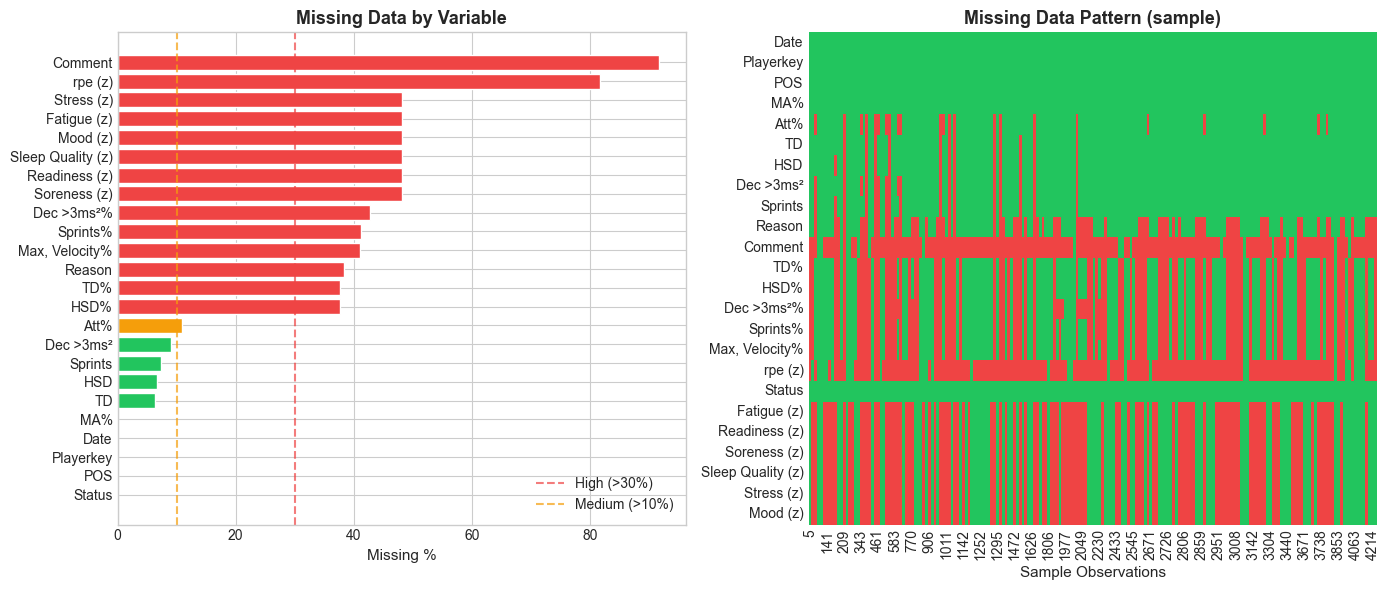

In [13]:
# Missing data heatmap
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart of missing percentages
ax1 = axes[0]
colors = ['#EF4444' if x > 30 else '#F59E0B' if x > 10 else '#22C55E' 
          for x in missing['Missing %']]
bars = ax1.barh(missing.index, missing['Missing %'], color=colors, edgecolor='white')
ax1.set_xlabel('Missing %', fontsize=11)
ax1.set_title('Missing Data by Variable', fontsize=13, fontweight='bold')
ax1.axvline(x=30, color='#EF4444', linestyle='--', alpha=0.7, label='High (>30%)')
ax1.axvline(x=10, color='#F59E0B', linestyle='--', alpha=0.7, label='Medium (>10%)')
ax1.legend(loc='lower right')
ax1.invert_yaxis()

# Missing data matrix (sample)
ax2 = axes[1]
sample_idx = np.random.choice(len(df), min(200, len(df)), replace=False)
sample_idx.sort()
missing_matrix = df.iloc[sample_idx].isna().astype(int)
sns.heatmap(missing_matrix.T, cmap=['#22C55E', '#EF4444'], cbar=False, ax=ax2,
            yticklabels=df.columns)
ax2.set_xlabel('Sample Observations', fontsize=11)
ax2.set_title('Missing Data Pattern (sample)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

C:\Users\U0152019\AppData\Local\Temp\ipykernel_28248\813118100.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  player_missing = df.groupby('Playerkey').apply(


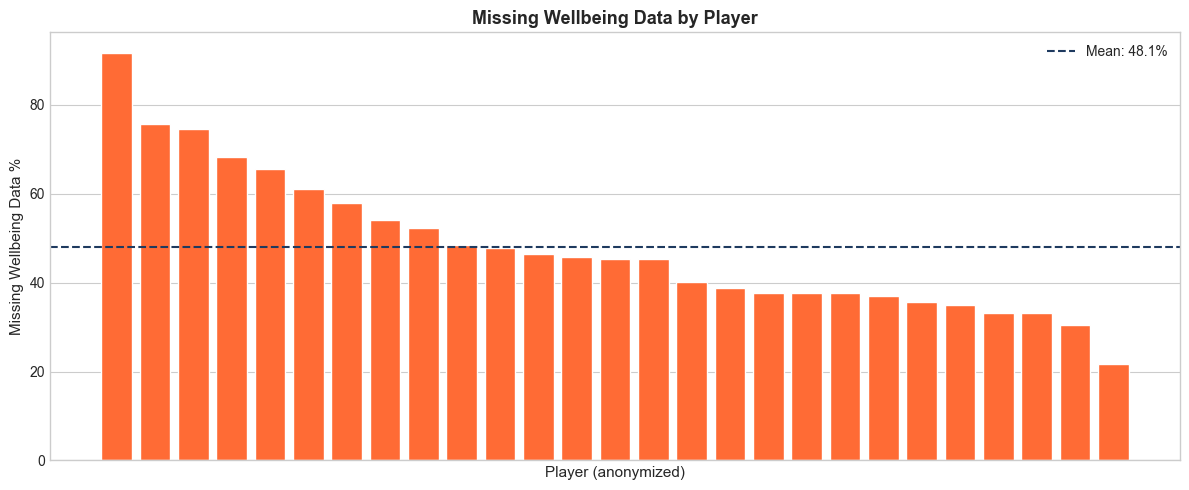


Player missing wellbeing data: 48.1% ± 16.2%


In [14]:
# Missing data by player
player_missing = df.groupby('Playerkey').apply(
    lambda x: x[WELLBEING_COLS].isna().mean().mean() * 100
).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 5))
bars = ax.bar(range(len(player_missing)), player_missing.values, 
              color=COLORS['accent'], edgecolor='white')
ax.set_xlabel('Player (anonymized)', fontsize=11)
ax.set_ylabel('Missing Wellbeing Data %', fontsize=11)
ax.set_title('Missing Wellbeing Data by Player', fontsize=13, fontweight='bold')
ax.axhline(y=player_missing.mean(), color=COLORS['primary'], linestyle='--', 
           label=f'Mean: {player_missing.mean():.1f}%')
ax.legend()
ax.set_xticks([])
plt.tight_layout()
plt.show()

print(f"\nPlayer missing wellbeing data: {player_missing.mean():.1f}% ± {player_missing.std():.1f}%")

C:\Users\U0152019\AppData\Local\Temp\ipykernel_28248\2530162668.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_missing = df.groupby('Date').apply(


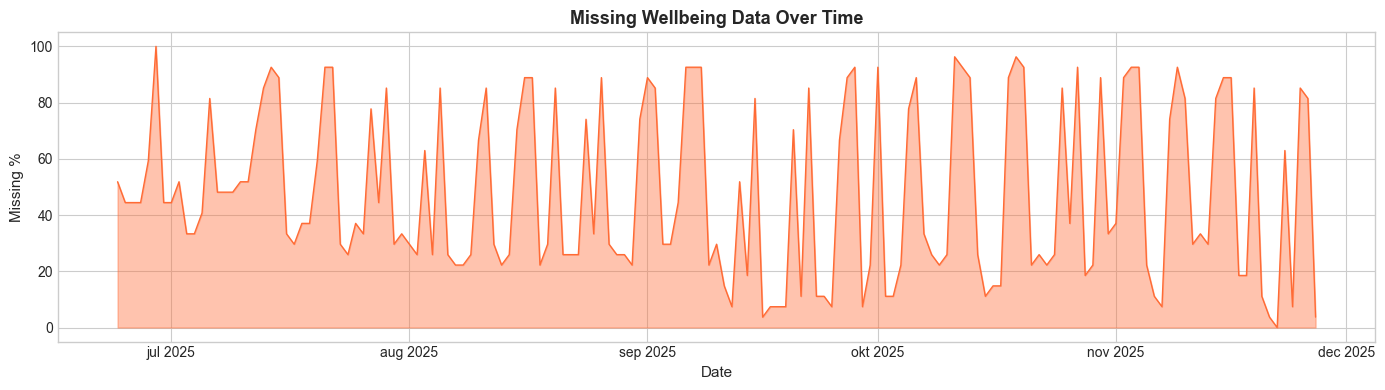

In [15]:
# Missing data over time
daily_missing = df.groupby('Date').apply(
    lambda x: x[WELLBEING_COLS].isna().mean().mean() * 100
)

fig, ax = plt.subplots(figsize=(14, 4))
ax.fill_between(daily_missing.index, daily_missing.values, alpha=0.4, color=COLORS['accent'])
ax.plot(daily_missing.index, daily_missing.values, color=COLORS['accent'], linewidth=1)
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Missing %', fontsize=11)
ax.set_title('Missing Wellbeing Data Over Time', fontsize=13, fontweight='bold')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.tight_layout()
plt.show()

---
## 4. Temporal Patterns

In [16]:
# Add temporal features
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['DayName'] = df['Date'].dt.day_name()
df['Week'] = df['Date'].dt.isocalendar().week
df['Month'] = df['Date'].dt.month
df['MonthName'] = df['Date'].dt.month_name()

print("✓ Temporal features added")

✓ Temporal features added


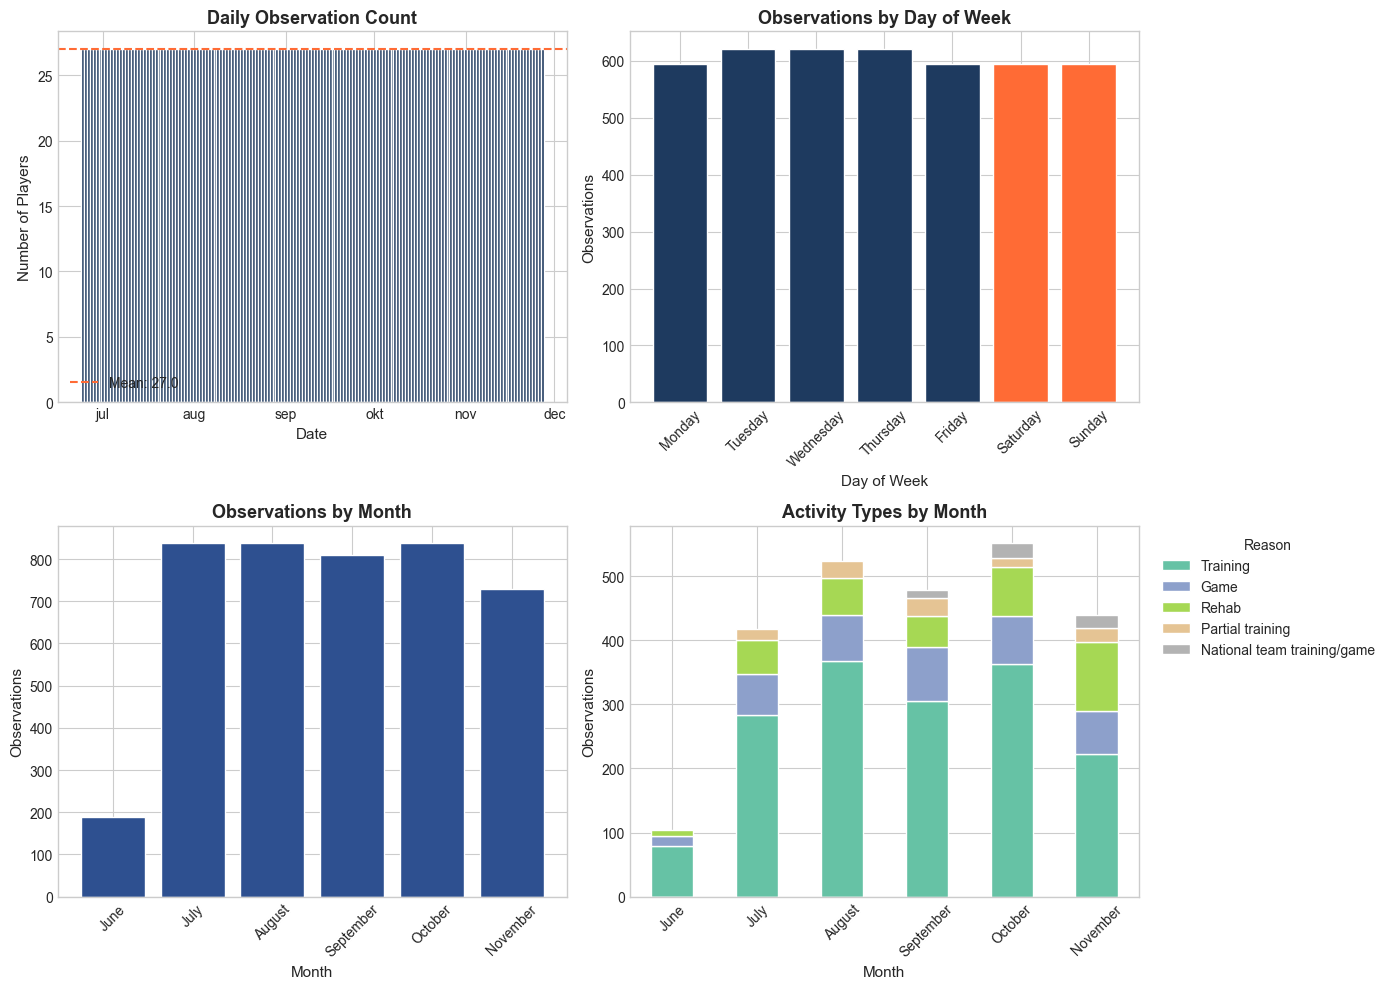

In [17]:
# Observations per day
daily_counts = df.groupby('Date').size()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time series of daily observations
ax1 = axes[0, 0]
ax1.bar(daily_counts.index, daily_counts.values, color=COLORS['primary'], 
        edgecolor='white', width=1)
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Number of Players', fontsize=11)
ax1.set_title('Daily Observation Count', fontsize=13, fontweight='bold')
ax1.axhline(y=daily_counts.mean(), color=COLORS['accent'], linestyle='--',
            label=f'Mean: {daily_counts.mean():.1f}')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.legend()

# Day of week distribution
ax2 = axes[0, 1]
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_counts = df['DayName'].value_counts().reindex(dow_order)
colors_dow = [COLORS['primary'] if d not in ['Saturday', 'Sunday'] else COLORS['accent'] 
              for d in dow_order]
ax2.bar(dow_order, dow_counts.values, color=colors_dow, edgecolor='white')
ax2.set_xlabel('Day of Week', fontsize=11)
ax2.set_ylabel('Observations', fontsize=11)
ax2.set_title('Observations by Day of Week', fontsize=13, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)

# Monthly distribution
ax3 = axes[1, 0]
month_order = ['June', 'July', 'August', 'September', 'October', 'November']
month_counts = df['MonthName'].value_counts().reindex(month_order)
ax3.bar(month_order, month_counts.values, color=COLORS['secondary'], edgecolor='white')
ax3.set_xlabel('Month', fontsize=11)
ax3.set_ylabel('Observations', fontsize=11)
ax3.set_title('Observations by Month', fontsize=13, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)

# Reason/Activity type over time
ax4 = axes[1, 1]
reason_time = df.groupby(['MonthName', 'Reason']).size().unstack(fill_value=0)
reason_time = reason_time.reindex(month_order)
top_reasons = df['Reason'].value_counts().head(5).index.tolist()
reason_time[top_reasons].plot(kind='bar', stacked=True, ax=ax4, 
                               colormap='Set2', edgecolor='white')
ax4.set_xlabel('Month', fontsize=11)
ax4.set_ylabel('Observations', fontsize=11)
ax4.set_title('Activity Types by Month', fontsize=13, fontweight='bold')
ax4.legend(title='Reason', bbox_to_anchor=(1.02, 1), loc='upper left')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

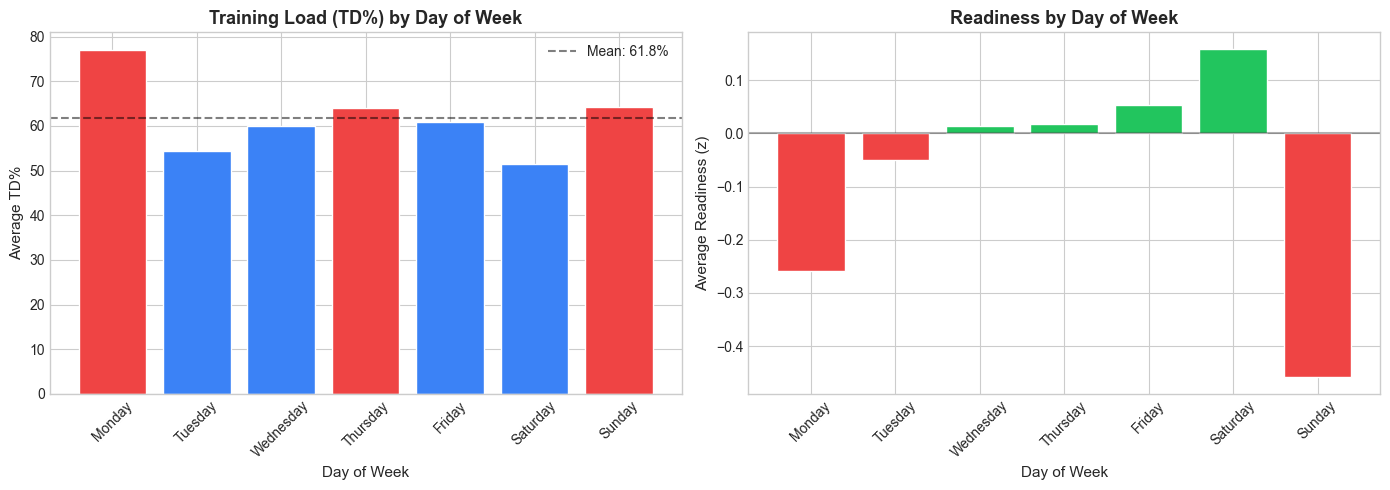

In [18]:
# Training load patterns by day of week
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Average TD% by day of week
ax1 = axes[0]
dow_load = df.groupby('DayName')['TD%'].mean().reindex(dow_order)
colors_load = ['#3B82F6' if v < dow_load.mean() else '#EF4444' for v in dow_load.values]
ax1.bar(dow_order, dow_load.values, color=colors_load, edgecolor='white')
ax1.axhline(y=dow_load.mean(), color='black', linestyle='--', alpha=0.5,
            label=f'Mean: {dow_load.mean():.1f}%')
ax1.set_xlabel('Day of Week', fontsize=11)
ax1.set_ylabel('Average TD%', fontsize=11)
ax1.set_title('Training Load (TD%) by Day of Week', fontsize=13, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()

# Average Readiness by day of week
ax2 = axes[1]
dow_readiness = df.groupby('DayName')['Readiness (z)'].mean().reindex(dow_order)
colors_ready = ['#22C55E' if v > 0 else '#EF4444' for v in dow_readiness.values]
ax2.bar(dow_order, dow_readiness.values, color=colors_ready, edgecolor='white')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.set_xlabel('Day of Week', fontsize=11)
ax2.set_ylabel('Average Readiness (z)', fontsize=11)
ax2.set_title('Readiness by Day of Week', fontsize=13, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

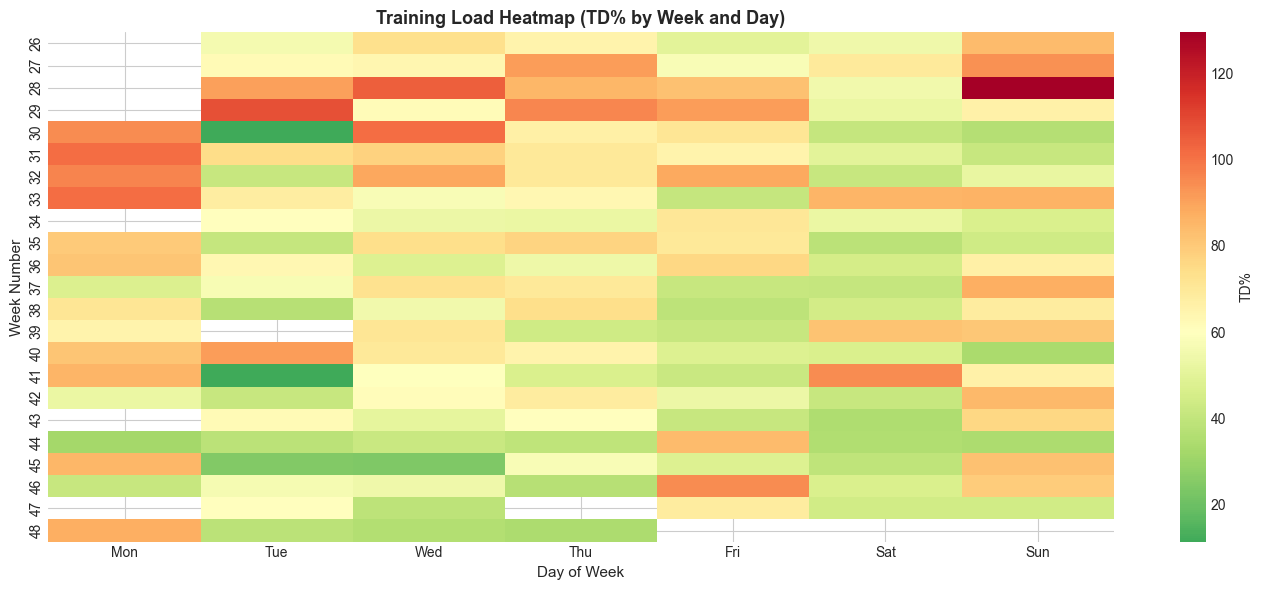

In [19]:
# Weekly patterns heatmap
fig, ax = plt.subplots(figsize=(14, 6))

# Create pivot table: Week vs DayOfWeek for TD%
heatmap_data = df.pivot_table(
    values='TD%', 
    index='Week', 
    columns='DayOfWeek', 
    aggfunc='mean'
)
heatmap_data.columns = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

sns.heatmap(heatmap_data, cmap='RdYlGn_r', center=60, annot=False,
            cbar_kws={'label': 'TD%'}, ax=ax)
ax.set_xlabel('Day of Week', fontsize=11)
ax.set_ylabel('Week Number', fontsize=11)
ax.set_title('Training Load Heatmap (TD% by Week and Day)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

---
## 5. Distribution Analysis

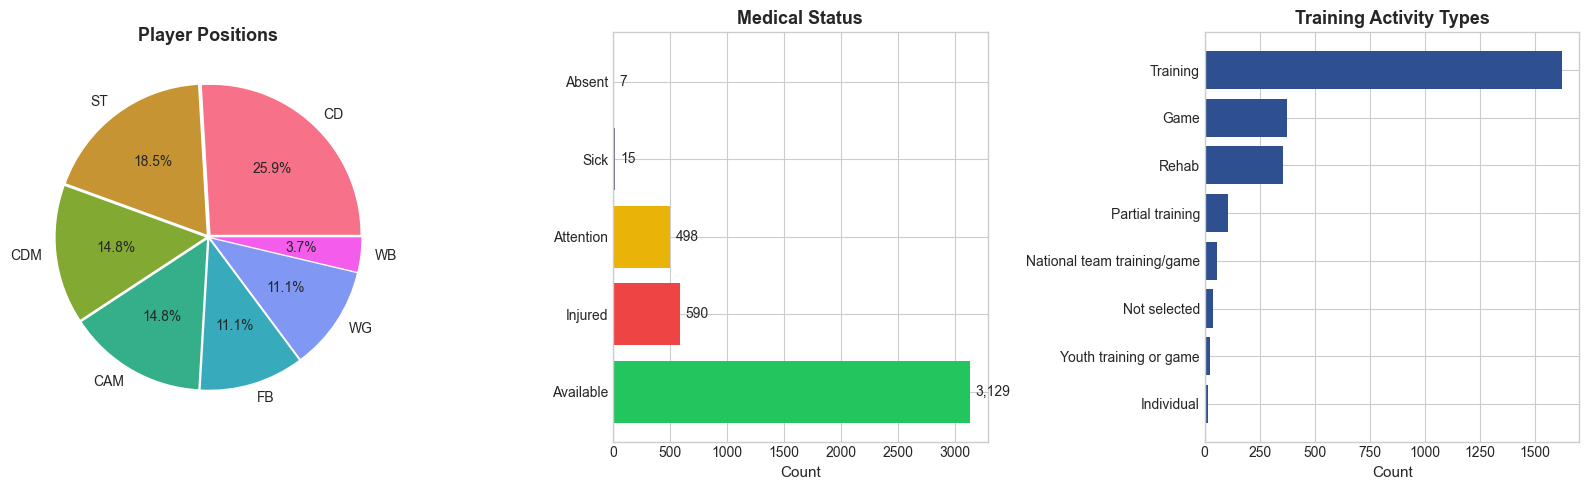

In [20]:
# Categorical variables distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Position distribution
ax1 = axes[0]
pos_counts = df['POS'].value_counts()
wedges, texts, autotexts = ax1.pie(pos_counts.values, labels=pos_counts.index, 
                                   autopct='%1.1f%%', colors=sns.color_palette('husl', len(pos_counts)),
                                   explode=[0.02]*len(pos_counts))
ax1.set_title('Player Positions', fontsize=13, fontweight='bold')

# Status distribution
ax2 = axes[1]
status_counts = df['Status'].value_counts()
status_colors = [COLORS['available'], COLORS['injured'], COLORS['attention'], '#6B7280', '#9CA3AF']
bars = ax2.barh(status_counts.index, status_counts.values, color=status_colors[:len(status_counts)])
ax2.set_xlabel('Count', fontsize=11)
ax2.set_title('Medical Status', fontsize=13, fontweight='bold')
for bar, count in zip(bars, status_counts.values):
    ax2.text(count + 50, bar.get_y() + bar.get_height()/2, f'{count:,}', 
             va='center', fontsize=10)

# Reason distribution
ax3 = axes[2]
reason_counts = df['Reason'].value_counts().head(8)
ax3.barh(reason_counts.index, reason_counts.values, color=COLORS['secondary'])
ax3.set_xlabel('Count', fontsize=11)
ax3.set_title('Training Activity Types', fontsize=13, fontweight='bold')
ax3.invert_yaxis()

plt.tight_layout()
plt.show()

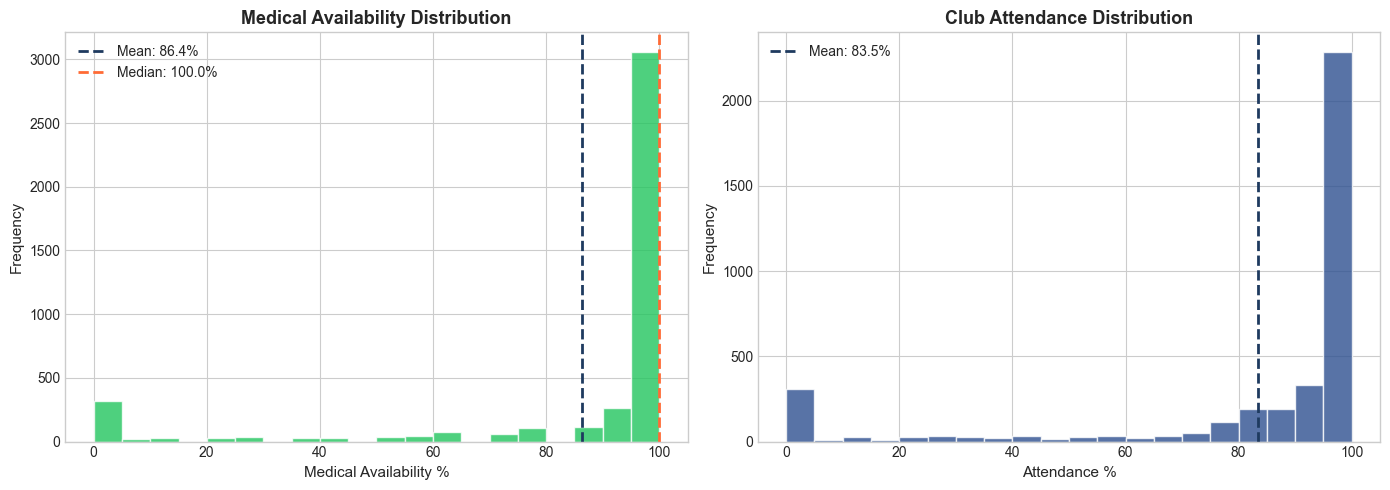

In [21]:
# Availability metrics (MA% and Att%)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MA% distribution
ax1 = axes[0]
ax1.hist(df['MA%'], bins=20, color=COLORS['available'], edgecolor='white', alpha=0.8)
ax1.axvline(x=df['MA%'].mean(), color=COLORS['primary'], linestyle='--', linewidth=2,
            label=f'Mean: {df["MA%"].mean():.1f}%')
ax1.axvline(x=df['MA%'].median(), color=COLORS['accent'], linestyle='--', linewidth=2,
            label=f'Median: {df["MA%"].median():.1f}%')
ax1.set_xlabel('Medical Availability %', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Medical Availability Distribution', fontsize=13, fontweight='bold')
ax1.legend()

# Att% distribution
ax2 = axes[1]
ax2.hist(df['Att%'].dropna(), bins=20, color=COLORS['secondary'], edgecolor='white', alpha=0.8)
ax2.axvline(x=df['Att%'].mean(), color=COLORS['primary'], linestyle='--', linewidth=2,
            label=f'Mean: {df["Att%"].mean():.1f}%')
ax2.set_xlabel('Attendance %', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Club Attendance Distribution', fontsize=13, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

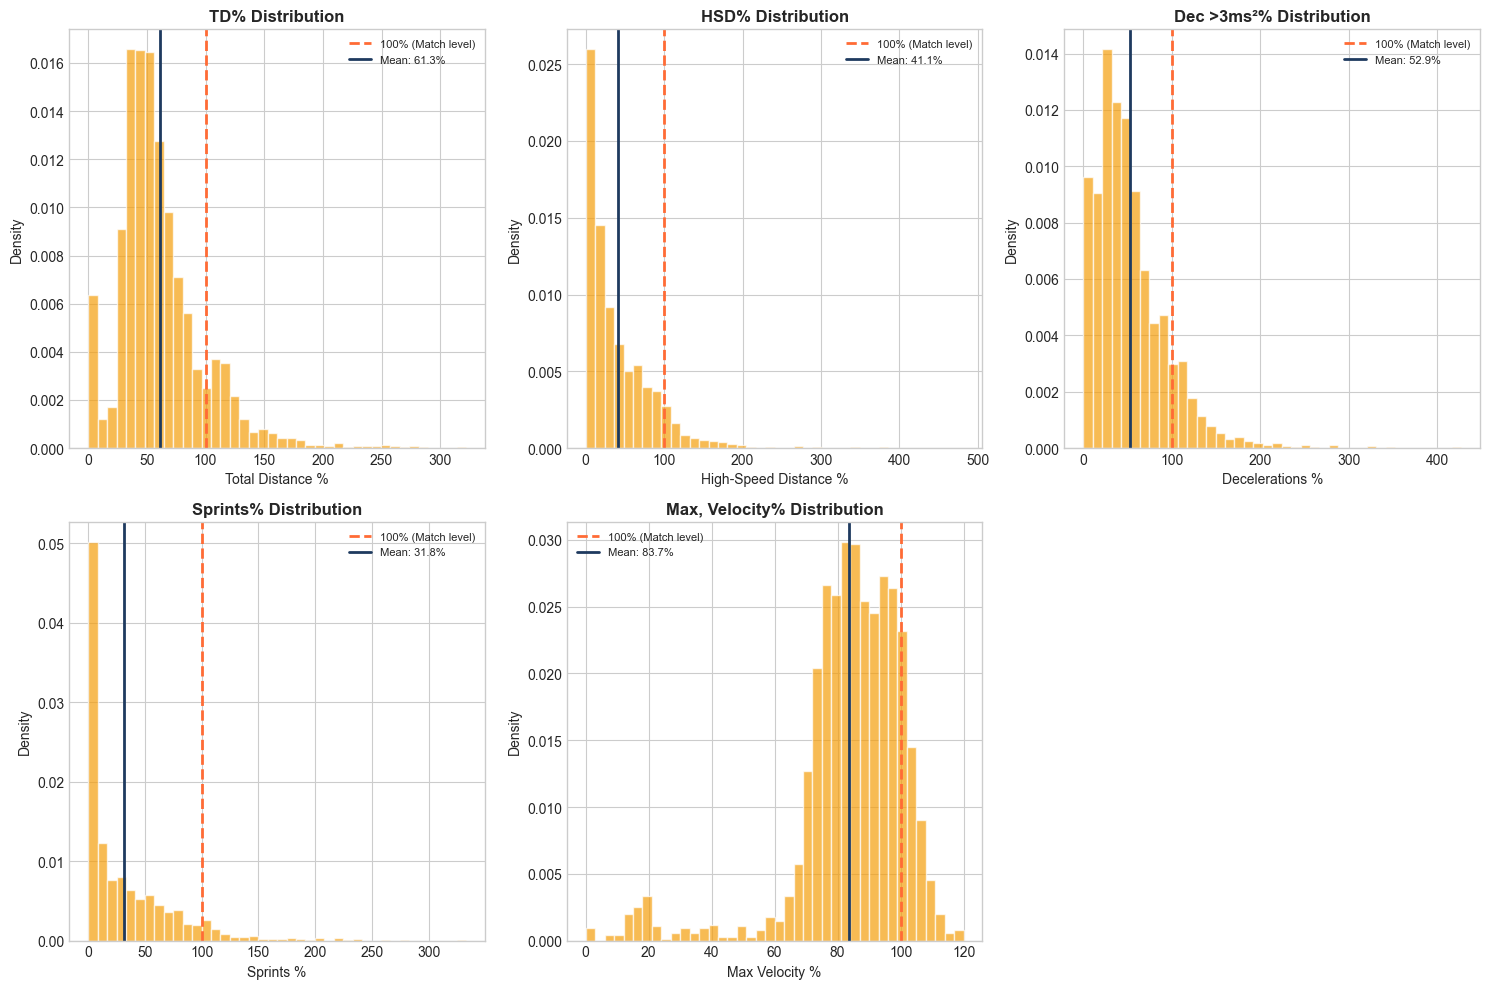

In [22]:
# Benchmark percentage distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

benchmark_labels = {
    'TD%': 'Total Distance %',
    'HSD%': 'High-Speed Distance %',
    'Dec >3ms²%': 'Decelerations %',
    'Sprints%': 'Sprints %',
    'Max, Velocity%': 'Max Velocity %'
}

for i, col in enumerate(BENCHMARK_COLS):
    ax = axes[i]
    data = df[col].dropna()
    
    # Histogram with KDE
    ax.hist(data, bins=40, density=True, alpha=0.7, color=COLORS['previous'], edgecolor='white')
    
    # Add 100% reference line
    ax.axvline(x=100, color=COLORS['accent'], linestyle='--', linewidth=2, label='100% (Match level)')
    ax.axvline(x=data.mean(), color=COLORS['primary'], linestyle='-', linewidth=2,
               label=f'Mean: {data.mean():.1f}%')
    
    ax.set_xlabel(benchmark_labels[col], fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8)

# Hide empty subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

---
## 6. ACWR Analysis

The **Acute:Chronic Workload Ratio (ACWR)** compares recent load (7-day) to established baseline (42-day). 
- **Sweet spot**: 0.8–1.3 (optimal training zone)
- **Danger zone**: >1.5 (elevated injury risk)

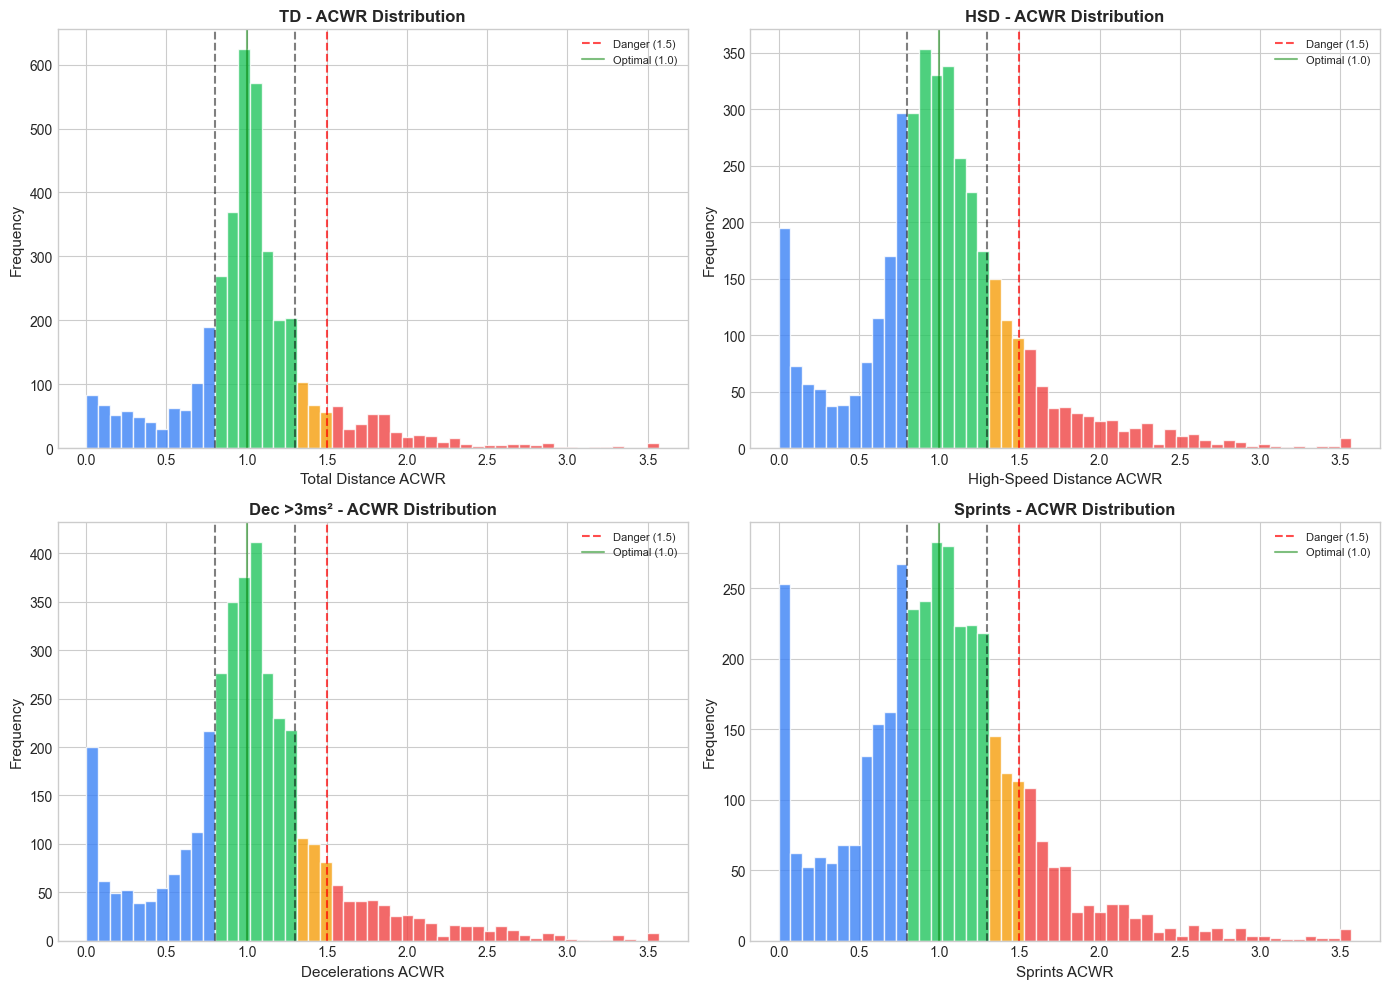


ACWR Zone Distribution:
------------------------------------------------------------
TD           | Under:  19.0% | Sweet:  64.8% | Caution:   5.6% | Danger:  10.6%
HSD          | Under:  28.0% | Sweet:  50.5% | Caution:   9.1% | Danger:  12.4%
Dec >3ms²    | Under:  24.9% | Sweet:  55.6% | Caution:   7.6% | Danger:  11.9%
Sprints      | Under:  32.8% | Sweet:  43.5% | Caution:   9.6% | Danger:  14.0%


In [23]:
# ACWR distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

acwr_labels = {
    'TD': 'Total Distance ACWR',
    'HSD': 'High-Speed Distance ACWR',
    'Dec >3ms²': 'Decelerations ACWR',
    'Sprints': 'Sprints ACWR'
}

for i, col in enumerate(ACWR_COLS):
    ax = axes[i]
    data = df[col].dropna()
    
    # Create bins for coloring
    bins = np.linspace(0, data.max(), 50)
    n, bins_edges, patches = ax.hist(data, bins=bins, edgecolor='white', alpha=0.8)
    
    # Color by zone
    for patch, left_edge in zip(patches, bins_edges[:-1]):
        if left_edge < 0.8:
            patch.set_facecolor('#3B82F6')  # Undertraining
        elif left_edge <= 1.3:
            patch.set_facecolor('#22C55E')  # Sweet spot
        elif left_edge <= 1.5:
            patch.set_facecolor('#F59E0B')  # Caution
        else:
            patch.set_facecolor('#EF4444')  # Danger
    
    # Zone lines
    ax.axvline(x=0.8, color='black', linestyle='--', alpha=0.5)
    ax.axvline(x=1.3, color='black', linestyle='--', alpha=0.5)
    ax.axvline(x=1.5, color='red', linestyle='--', alpha=0.7, label='Danger (1.5)')
    ax.axvline(x=1.0, color='green', linestyle='-', alpha=0.5, label='Optimal (1.0)')
    
    ax.set_xlabel(acwr_labels[col], fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'{col} - ACWR Distribution', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

# Print zone percentages
print("\nACWR Zone Distribution:")
print("-" * 60)
for col in ACWR_COLS:
    data = df[col].dropna()
    under = (data < 0.8).mean() * 100
    sweet = ((data >= 0.8) & (data <= 1.3)).mean() * 100
    caution = ((data > 1.3) & (data <= 1.5)).mean() * 100
    danger = (data > 1.5).mean() * 100
    print(f"{col:12} | Under: {under:5.1f}% | Sweet: {sweet:5.1f}% | Caution: {caution:5.1f}% | Danger: {danger:5.1f}%")

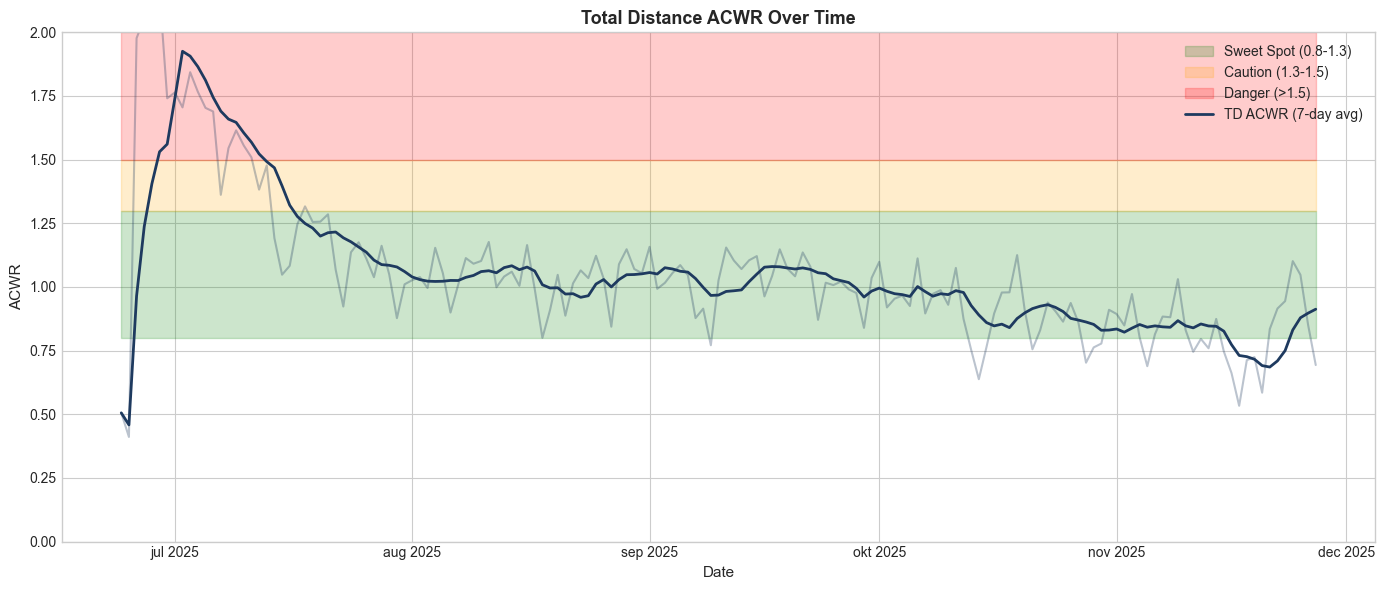

In [24]:
# ACWR over time
fig, ax = plt.subplots(figsize=(14, 6))

# Rolling mean of TD ACWR over time
daily_acwr = df.groupby('Date')['TD'].mean()
rolling_acwr = daily_acwr.rolling(window=7, min_periods=1).mean()

ax.fill_between(rolling_acwr.index, 0.8, 1.3, alpha=0.2, color='green', label='Sweet Spot (0.8-1.3)')
ax.fill_between(rolling_acwr.index, 1.3, 1.5, alpha=0.2, color='orange', label='Caution (1.3-1.5)')
ax.fill_between(rolling_acwr.index, 1.5, 2.0, alpha=0.2, color='red', label='Danger (>1.5)')

ax.plot(daily_acwr.index, daily_acwr.values, alpha=0.3, color=COLORS['primary'])
ax.plot(rolling_acwr.index, rolling_acwr.values, color=COLORS['primary'], linewidth=2, label='TD ACWR (7-day avg)')

ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('ACWR', fontsize=11)
ax.set_title('Total Distance ACWR Over Time', fontsize=13, fontweight='bold')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.legend(loc='upper right')
ax.set_ylim(0, 2)

plt.tight_layout()
plt.show()

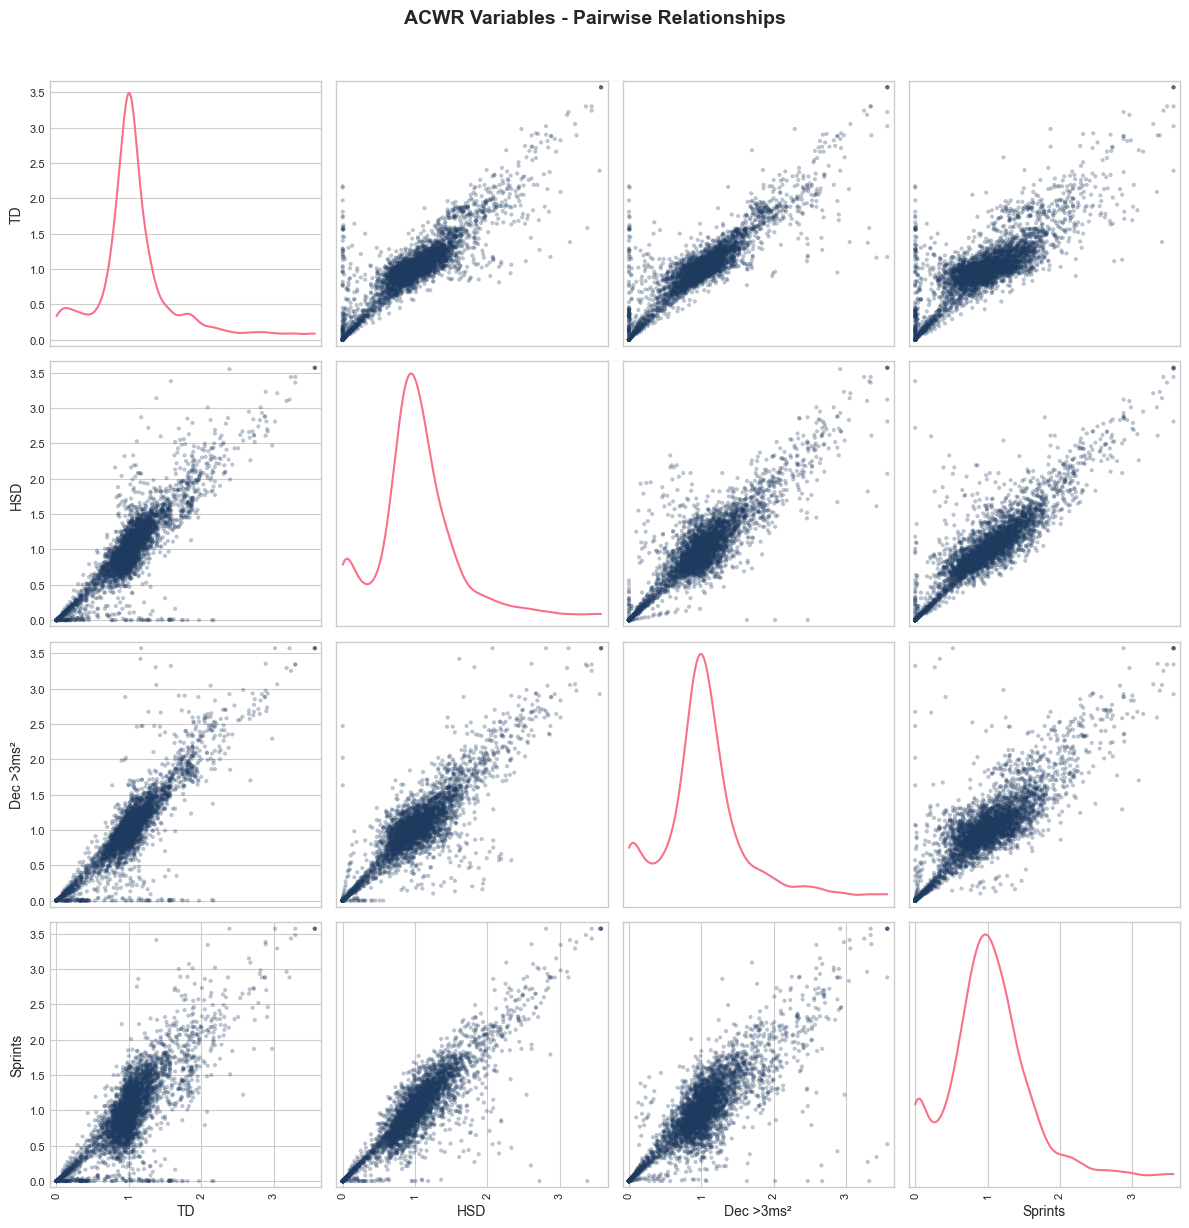

In [25]:
# ACWR scatter matrix
acwr_data = df[ACWR_COLS].dropna()
scatter_matrix = pd.plotting.scatter_matrix(
    acwr_data, 
    figsize=(12, 12), 
    diagonal='kde',
    alpha=0.3,
    color=COLORS['primary']
)

plt.suptitle('ACWR Variables - Pairwise Relationships', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 7. Subjective Wellbeing Analysis

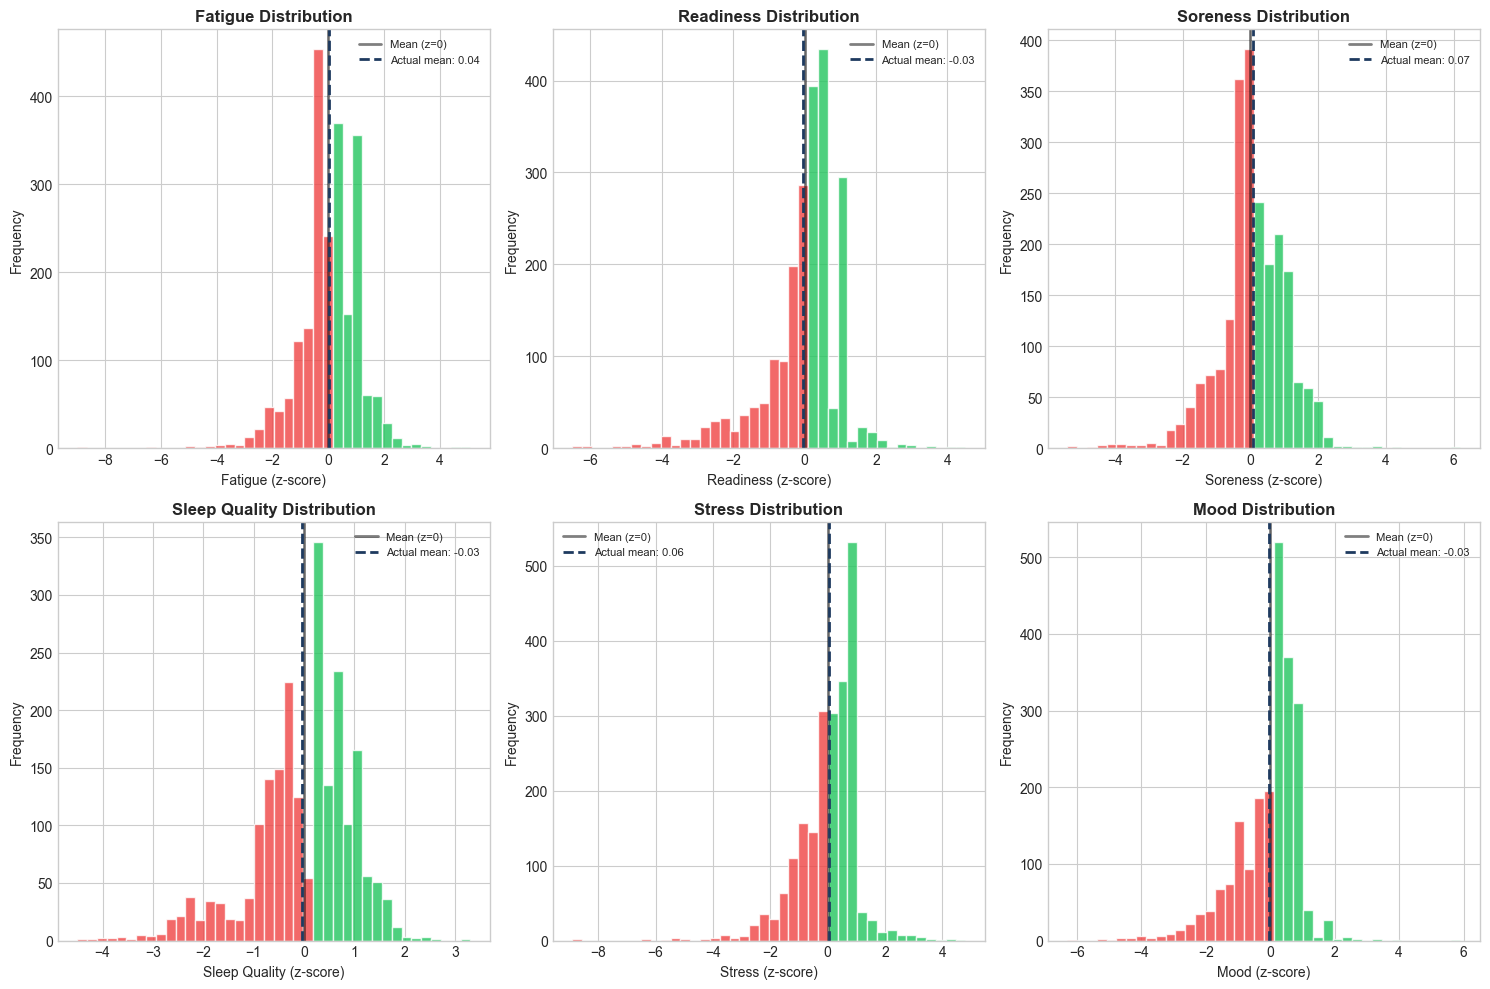

In [26]:
# Wellbeing distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

wellbeing_labels = {
    'Fatigue (z)': 'Fatigue',
    'Readiness (z)': 'Readiness',
    'Soreness (z)': 'Soreness',
    'Sleep Quality (z)': 'Sleep Quality',
    'Stress (z)': 'Stress',
    'Mood (z)': 'Mood'
}

for i, col in enumerate(WELLBEING_COLS):
    ax = axes[i]
    data = df[col].dropna()
    
    # Histogram
    n, bins, patches = ax.hist(data, bins=40, edgecolor='white', alpha=0.8)
    
    # Color by positive/negative
    for patch, left_edge in zip(patches, bins[:-1]):
        if left_edge < 0:
            patch.set_facecolor('#EF4444')  # Negative z-score
        else:
            patch.set_facecolor('#22C55E')  # Positive z-score
    
    ax.axvline(x=0, color='black', linestyle='-', linewidth=2, alpha=0.5, label='Mean (z=0)')
    ax.axvline(x=data.mean(), color=COLORS['primary'], linestyle='--', linewidth=2,
               label=f'Actual mean: {data.mean():.2f}')
    
    ax.set_xlabel(f'{wellbeing_labels[col]} (z-score)', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f'{wellbeing_labels[col]} Distribution', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

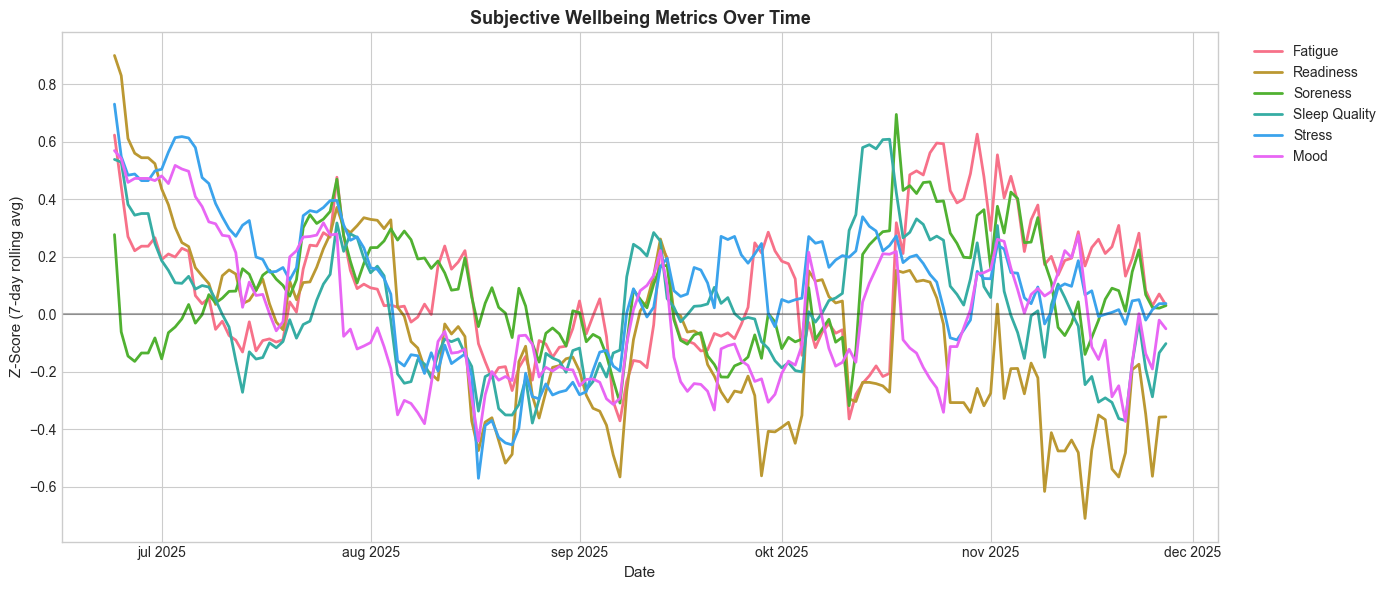

In [27]:
# Wellbeing over time
fig, ax = plt.subplots(figsize=(14, 6))

colors_wellbeing = sns.color_palette('husl', len(WELLBEING_COLS))

for i, col in enumerate(WELLBEING_COLS):
    daily_mean = df.groupby('Date')[col].mean()
    rolling = daily_mean.rolling(window=7, min_periods=1).mean()
    ax.plot(rolling.index, rolling.values, label=wellbeing_labels[col], 
            linewidth=2, color=colors_wellbeing[i])

ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Z-Score (7-day rolling avg)', fontsize=11)
ax.set_title('Subjective Wellbeing Metrics Over Time', fontsize=13, fontweight='bold')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [28]:
# Wellbeing by day of week
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(WELLBEING_COLS):
    ax = axes[i]
    dow_data = df.groupby('DayName')[col].agg(['mean', 'std']).reindex(dow_order)
    
    colors = ['#22C55E' if v > 0 else '#EF4444' for v in dow_data['mean']]
    ax.bar(dow_order, dow_data['mean'], yerr=dow_data['std']/2, 
           color=colors, edgecolor='white', capsize=3, alpha=0.8)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax.set_xlabel('Day of Week', fontsize=10)
    ax.set_ylabel('Mean Z-Score', fontsize=10)
    ax.set_title(f'{wellbeing_labels[col]} by Day of Week', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

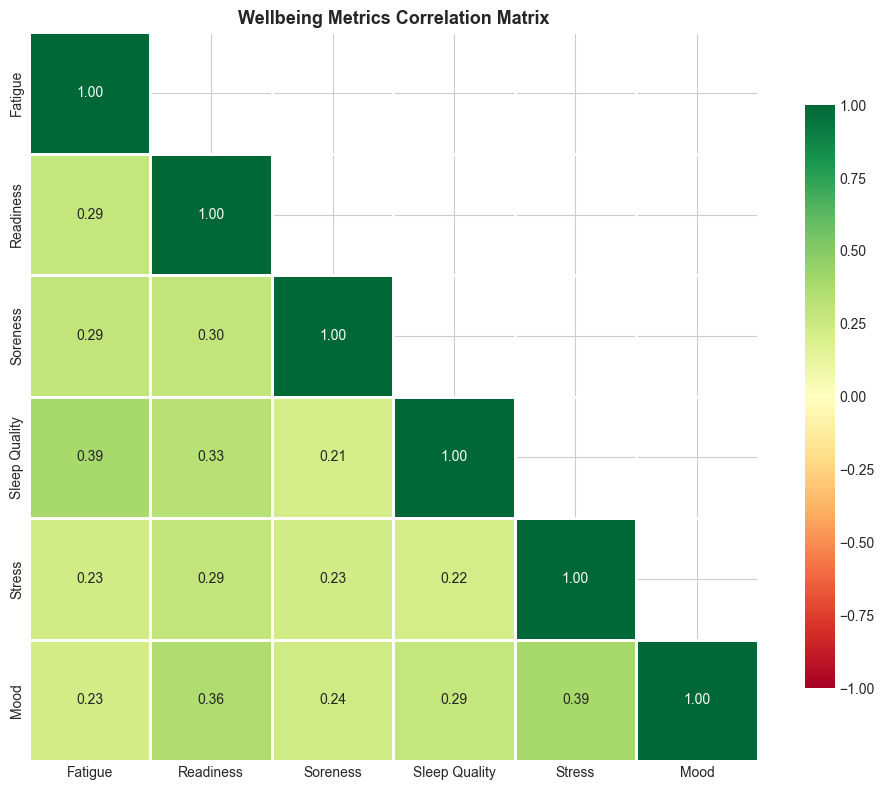

In [29]:
# Wellbeing correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))

wellbeing_corr = df[WELLBEING_COLS].corr()

# Create labels without (z)
labels = [wellbeing_labels[col] for col in WELLBEING_COLS]

mask = np.triu(np.ones_like(wellbeing_corr, dtype=bool), k=1)
sns.heatmap(wellbeing_corr, mask=mask, annot=True, fmt='.2f', cmap='RdYlGn',
            center=0, square=True, linewidths=1, cbar_kws={'shrink': 0.8},
            xticklabels=labels, yticklabels=labels, ax=ax,
            vmin=-1, vmax=1)
ax.set_title('Wellbeing Metrics Correlation Matrix', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

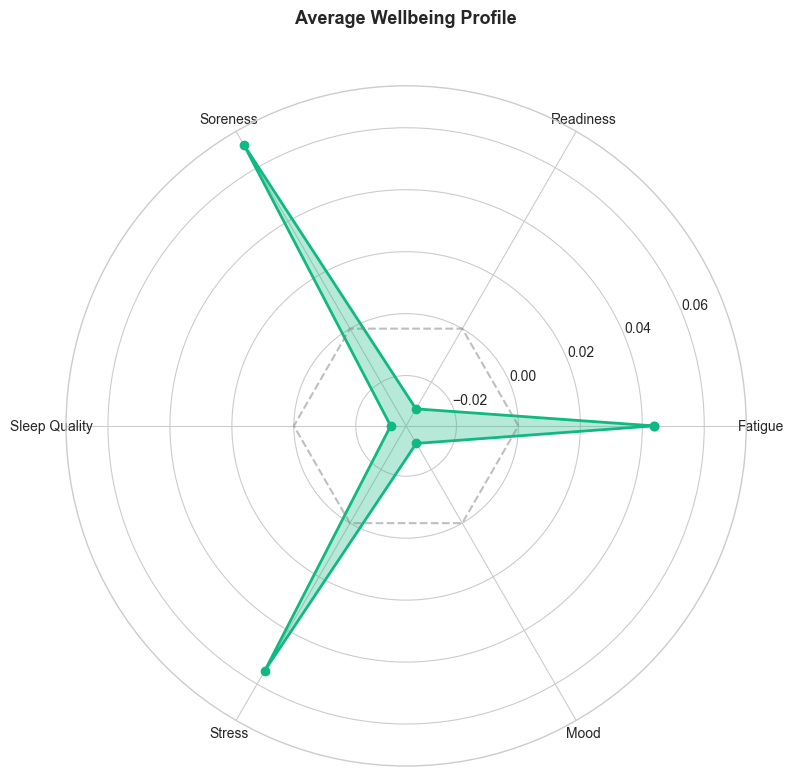

In [30]:
# Radar chart of average wellbeing
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))

# Calculate means
means = [df[col].mean() for col in WELLBEING_COLS]
labels = [wellbeing_labels[col] for col in WELLBEING_COLS]

# Number of variables
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop
means += means[:1]

ax.plot(angles, means, 'o-', linewidth=2, color=COLORS['current'])
ax.fill(angles, means, alpha=0.3, color=COLORS['current'])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.set_title('Average Wellbeing Profile', fontsize=13, fontweight='bold', y=1.08)

# Add reference circle at 0
zero_circle = [0] * (num_vars + 1)
ax.plot(angles, zero_circle, '--', color='gray', alpha=0.5)

plt.tight_layout()
plt.show()

---
## 8. Correlation Analysis

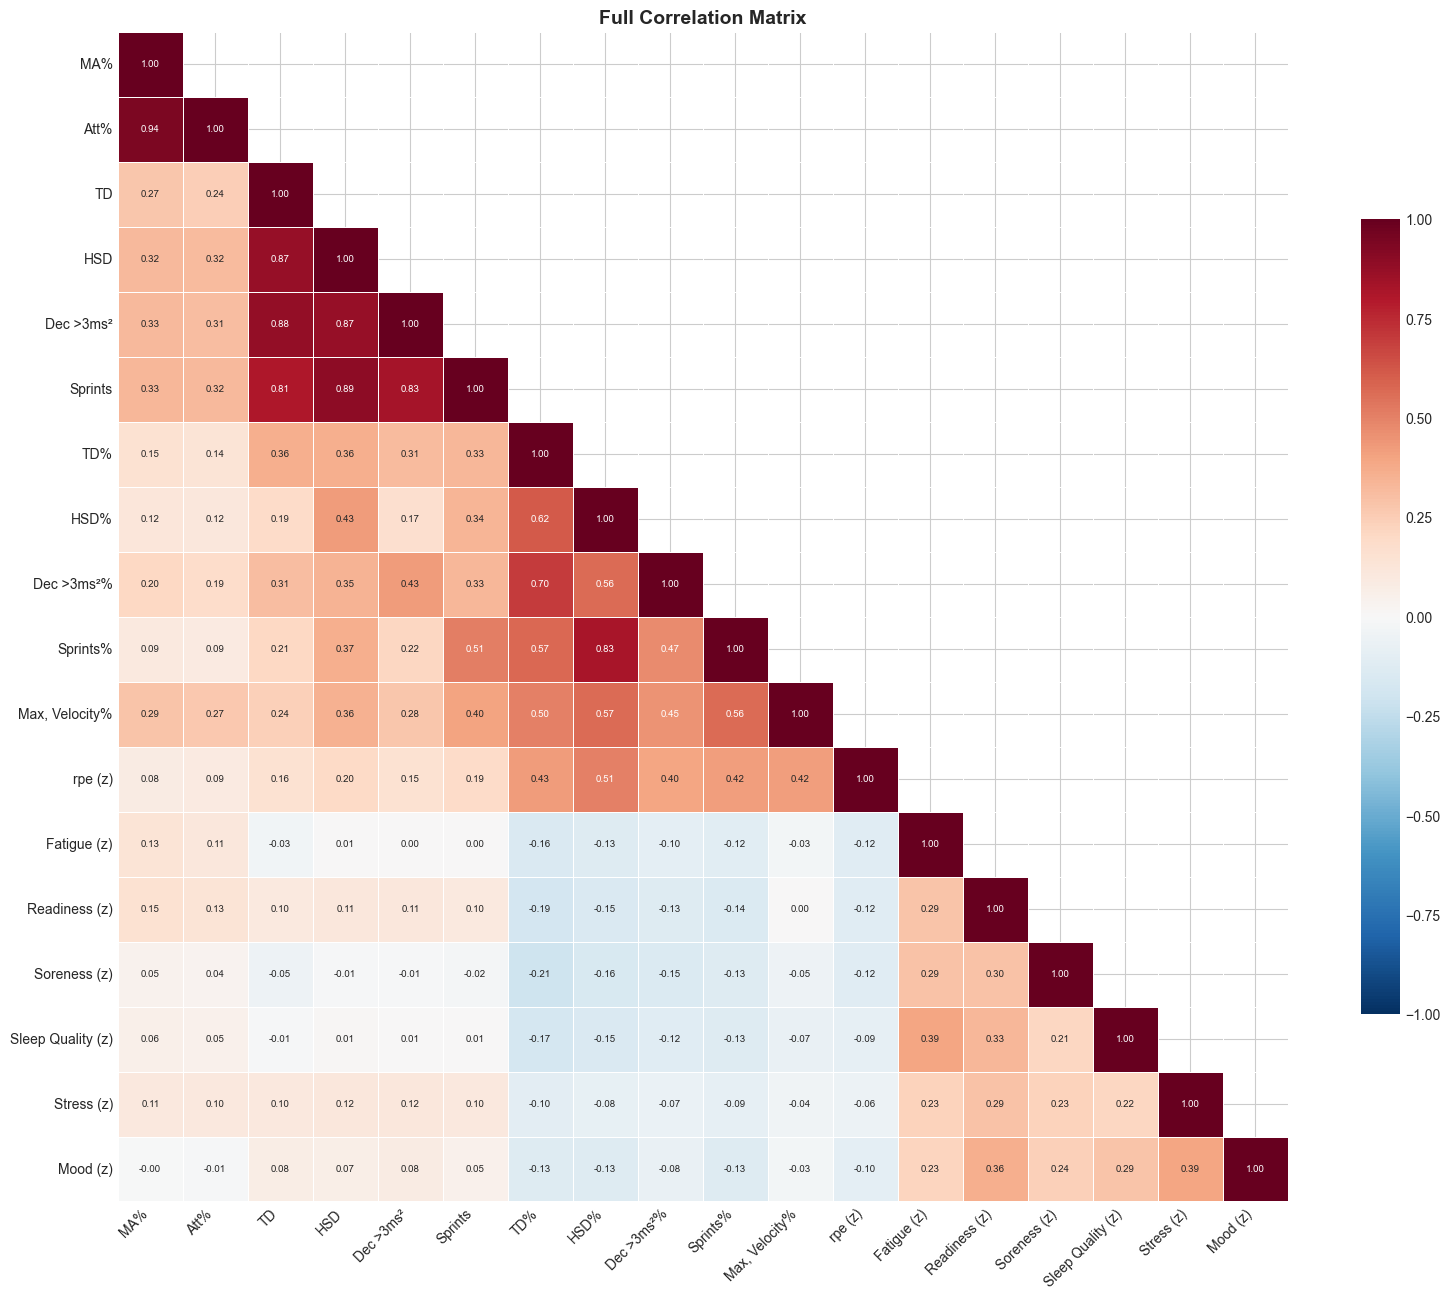

In [31]:
# Full correlation matrix for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove temporal features we added
numeric_cols = [c for c in numeric_cols if c not in ['DayOfWeek', 'Week', 'Month']]

fig, ax = plt.subplots(figsize=(16, 14))

corr_matrix = df[numeric_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=0.5, cbar_kws={'shrink': 0.6},
            ax=ax, annot_kws={'size': 7}, vmin=-1, vmax=1)
ax.set_title('Full Correlation Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

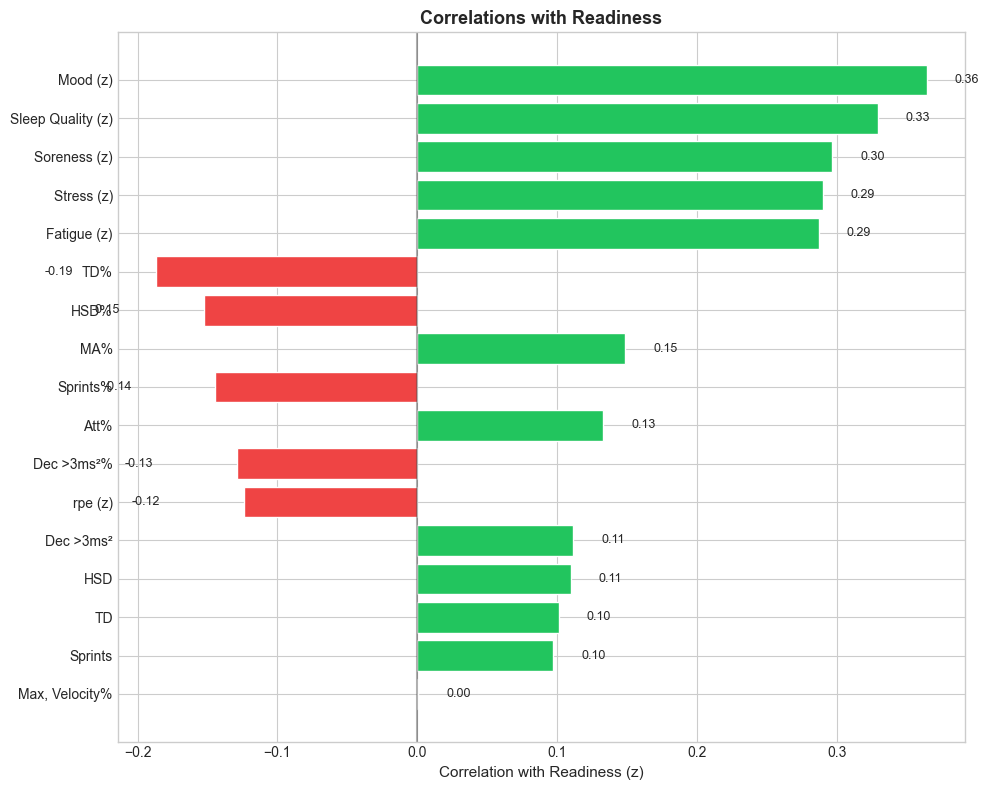


Top 5 positive correlations with Readiness:
Mood (z)            0.36
Sleep Quality (z)   0.33
Soreness (z)        0.30
Stress (z)          0.29
Fatigue (z)         0.29
Name: Readiness (z), dtype: float64

Top 5 negative correlations with Readiness:
Dec >3ms²        0.11
HSD              0.11
TD               0.10
Sprints          0.10
Max, Velocity%   0.00
Name: Readiness (z), dtype: float64


In [32]:
# Top correlations with Readiness
readiness_corr = df[numeric_cols].corr()['Readiness (z)'].drop('Readiness (z)').sort_values(key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#22C55E' if x > 0 else '#EF4444' for x in readiness_corr.values]
ax.barh(readiness_corr.index, readiness_corr.values, color=colors, edgecolor='white')
ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
ax.set_xlabel('Correlation with Readiness (z)', fontsize=11)
ax.set_title('Correlations with Readiness', fontsize=13, fontweight='bold')
ax.invert_yaxis()

# Add correlation values
for i, (idx, val) in enumerate(readiness_corr.items()):
    ax.text(val + 0.02 if val > 0 else val - 0.08, i, f'{val:.2f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\nTop 5 positive correlations with Readiness:")
print(readiness_corr.head())
print("\nTop 5 negative correlations with Readiness:")
print(readiness_corr.tail())

In [33]:
# Load vs Wellbeing scatter plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

scatter_pairs = [
    ('TD%', 'Readiness (z)', 'Training Load vs Readiness'),
    ('TD%', 'Fatigue (z)', 'Training Load vs Fatigue'),
    ('TD', 'Readiness (z)', 'ACWR vs Readiness'),
    ('MA%', 'Readiness (z)', 'Medical Availability vs Readiness')
]

for i, (x_col, y_col, title) in enumerate(scatter_pairs):
    ax = axes[i]
    
    # Remove NaN
    mask = df[[x_col, y_col]].notna().all(axis=1)
    x_data = df.loc[mask, x_col]
    y_data = df.loc[mask, y_col]
    
    # Scatter with alpha
    ax.scatter(x_data, y_data, alpha=0.2, color=COLORS['primary'], s=20)
    
    # Add trend line
    z = np.polyfit(x_data, y_data, 1)
    p = np.poly1d(z)
    x_line = np.linspace(x_data.min(), x_data.max(), 100)
    ax.plot(x_line, p(x_line), color=COLORS['accent'], linewidth=2, label='Trend')
    
    # Correlation
    corr = x_data.corr(y_data)
    ax.set_xlabel(x_col, fontsize=11)
    ax.set_ylabel(y_col, fontsize=11)
    ax.set_title(f'{title}\n(r = {corr:.3f})', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

---
## 9. Player-Level Analysis

In [34]:
# Player summary statistics
player_summary = df.groupby('Playerkey').agg({
    'Date': ['min', 'max', 'count'],
    'MA%': 'mean',
    'TD%': 'mean',
    'Readiness (z)': 'mean',
    'Status': lambda x: (x == 'Available').mean() * 100
}).round(2)

player_summary.columns = ['First Date', 'Last Date', 'Observations', 
                          'Avg MA%', 'Avg TD%', 'Avg Readiness', 'Available %']
player_summary = player_summary.sort_values('Observations', ascending=False)

print("Player Summary (sorted by observations):")
player_summary

Player Summary (sorted by observations):


First Date  Last Date  Observations  Avg MA%  \
Playerkey                                                                       
01e047768bd5462db313dc7b053da3e4 2025-06-24 2025-11-27           157   100.00   
0ac7621bb96044809c754675760772ec 2025-06-24 2025-11-27           157    76.14   
0c0f73f392d24cce8825ce3340e0e195 2025-06-24 2025-11-27           157   100.00   
0e6b941a89564f01a59e6d44834f8056 2025-06-24 2025-11-27           157    98.75   
18be0fafb9344cd49faff3c699882e1a 2025-06-24 2025-11-27           157    88.08   
1a91049fef064bc5b8331cb32bc4037a 2025-06-24 2025-11-27           157    98.75   
3e559addd9854ed69d0b2f9b1991d5a9 2025-06-24 2025-11-27           157   100.00   
3f5360c7183b4c97909df2f0229cb527 2025-06-24 2025-11-27           157    98.84   
3fe89e3910484064aca50bc01ec54925 2025-06-24 2025-11-27           157    76.74   
4ecd42a2587c403f8fc0d9cdac4dfb79 2025-06-24 2025-11-27           157    81.08   
4f35959082b941638176b8812f0eff91 2025-06-24 2025-11-27           157    98.13   
54ddb27abee64a6da4c7564e641a0b5a 2025-06-24 2025-11-27           157    81.25   
62c3f3cac1b74bb68335ab6bbd4b8de1 2025-06-24 2025-11-27           157    92.45   
641104cbe4ba41f1baf874180482bcfb 2025-06-24 2025-11-27           157    97.50   
67350e6427614e86b1d4547caa753845 2025-06-24 2025-11-27           157    90.45   
6a06d1bef2374b4481c0b6f45b520563 2025-06-24 2025-11-27           157    98.75   
79ceaf95863d4b03970d28cf7303df92 2025-06-24 2025-11-27           157    89.80   
86361379cc814b0eb8e311b4c4f93ac6 2025-06-24 2025-11-27           157    91.09   
8ffb6d425b8d489ebb5d6b933e821b3d 2025-06-24 2025-11-27           157    73.12   
95f79931addc45c490bd4abc5adc4835 2025-06-24 2025-11-27           157   100.00   
9a553052203d46ada38780de98f68906 2025-06-24 2025-11-27           157    99.38   
ad6ee4cf8fc34be68dc144170c7af6b5 2025-06-24 2025-11-27           157    66.89   
b8ccc8cf23e044a987cbd895f7a1c700 2025-06-24 2025-11-27           157     3.55   
bc33e68773c145f88960ea94b49a2e01 2025-06-24 2025-11-27           157    93.67   
e7906a56cac946eea95089f299990d6f 2025-06-24 2025-11-27           157    59.58   
ea30b180cd48426b81b2cac516bb26a9 2025-06-24 2025-11-27           157    96.80   
ebb9544e5712498bb85dacb860439f94 2025-06-24 2025-11-27           157    82.81   

                                  Avg TD%  Avg Readiness  Available %  
Playerkey                                                              
01e047768bd5462db313dc7b053da3e4    59.19          -0.18        96.82  
0ac7621bb96044809c754675760772ec    42.97          -0.15        66.88  
0c0f73f392d24cce8825ce3340e0e195    60.26          -0.13        95.54  
0e6b941a89564f01a59e6d44834f8056    63.03           0.02        95.54  
18be0fafb9344cd49faff3c699882e1a    51.64           0.07        75.80  
1a91049fef064bc5b8331cb32bc4037a   138.28           0.44        90.45  
3e559addd9854ed69d0b2f9b1991d5a9    70.13          -0.43       100.00  
3f5360c7183b4c97909df2f0229cb527    52.69           0.07        82.17  
3fe89e3910484064aca50bc01ec54925    46.11           0.42        54.78  
4ecd42a2587c403f8fc0d9cdac4dfb79    91.04          -0.36        64.33  
4f35959082b941638176b8812f0eff91    58.19           0.02        94.27  
54ddb27abee64a6da4c7564e641a0b5a    50.86           0.04        77.07  
62c3f3cac1b74bb68335ab6bbd4b8de1    50.59           0.21        59.87  
641104cbe4ba41f1baf874180482bcfb    61.44           0.23        71.97  
67350e6427614e86b1d4547caa753845    50.40          -0.02        74.52  
6a06d1bef2374b4481c0b6f45b520563    50.52           0.20        96.82  
79ceaf95863d4b03970d28cf7303df92    81.07          -0.09        68.15  
86361379cc814b0eb8e311b4c4f93ac6    51.67           1.00        79.62  
8ffb6d425b8d489ebb5d6b933e821b3d    52.64          -0.09        46.50  
95f79931addc45c490bd4abc5adc4835    64.33           0.34       100.00  
9a553052203d46ada38780de98f68906    65.88           0.10        96.82  
ad6ee4cf8fc34be68dc144170c7

In [35]:
# Player variability analysis
player_variability = df.groupby('Playerkey').agg({
    'Readiness (z)': ['mean', 'std'],
    'Fatigue (z)': ['mean', 'std'],
    'TD%': ['mean', 'std']
})
player_variability.columns = ['_'.join(col) for col in player_variability.columns]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Readiness mean vs std
ax1 = axes[0]
ax1.scatter(player_variability['Readiness (z)_mean'], 
            player_variability['Readiness (z)_std'],
            s=80, alpha=0.7, color=COLORS['current'], edgecolor='white')
ax1.set_xlabel('Mean Readiness (z)', fontsize=11)
ax1.set_ylabel('Std Readiness (z)', fontsize=11)
ax1.set_title('Player Readiness: Mean vs Variability', fontsize=12, fontweight='bold')
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

# Fatigue mean vs std
ax2 = axes[1]
ax2.scatter(player_variability['Fatigue (z)_mean'], 
            player_variability['Fatigue (z)_std'],
            s=80, alpha=0.7, color=COLORS['accent'], edgecolor='white')
ax2.set_xlabel('Mean Fatigue (z)', fontsize=11)
ax2.set_ylabel('Std Fatigue (z)', fontsize=11)
ax2.set_title('Player Fatigue: Mean vs Variability', fontsize=12, fontweight='bold')
ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.5)

# Training load mean vs std
ax3 = axes[2]
ax3.scatter(player_variability['TD%_mean'], 
            player_variability['TD%_std'],
            s=80, alpha=0.7, color=COLORS['previous'], edgecolor='white')
ax3.set_xlabel('Mean TD%', fontsize=11)
ax3.set_ylabel('Std TD%', fontsize=11)
ax3.set_title('Player Load: Mean vs Variability', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [36]:
# Player trajectories over time (sample of 5 players)
sample_players = df['Playerkey'].value_counts().head(5).index.tolist()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Readiness trajectories
ax1 = axes[0]
for i, player in enumerate(sample_players):
    player_data = df[df['Playerkey'] == player].sort_values('Date')
    rolling = player_data.set_index('Date')['Readiness (z)'].rolling('7D').mean()
    ax1.plot(rolling.index, rolling.values, label=f'Player {i+1}', linewidth=2, alpha=0.8)

ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Readiness (z) - 7D Rolling', fontsize=11)
ax1.set_title('Individual Player Readiness Trajectories', fontsize=13, fontweight='bold')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

# TD% trajectories  
ax2 = axes[1]
for i, player in enumerate(sample_players):
    player_data = df[df['Playerkey'] == player].sort_values('Date')
    rolling = player_data.set_index('Date')['TD%'].rolling('7D').mean()
    ax2.plot(rolling.index, rolling.values, label=f'Player {i+1}', linewidth=2, alpha=0.8)

ax2.axhline(y=100, color='red', linestyle='--', alpha=0.5, label='Match level')
ax2.set_xlabel('Date', fontsize=11)
ax2.set_ylabel('TD% - 7D Rolling', fontsize=11)
ax2.set_title('Individual Player Training Load Trajectories', fontsize=13, fontweight='bold')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

---
## 10. Position-Based Analysis

In [37]:
# Position summary
position_summary = df.groupby('POS').agg({
    'Playerkey': 'nunique',
    'TD%': 'mean',
    'HSD%': 'mean',
    'Sprints%': 'mean',
    'Readiness (z)': 'mean',
    'Fatigue (z)': 'mean'
}).round(2)

position_summary.columns = ['Players', 'Avg TD%', 'Avg HSD%', 'Avg Sprints%', 
                            'Avg Readiness', 'Avg Fatigue']
position_summary = position_summary.sort_values('Avg TD%', ascending=False)

print("Position Summary:")
position_summary

Position Summary:


Players  Avg TD%  Avg HSD%  Avg Sprints%  Avg Readiness  Avg Fatigue
POS                                                                      
WG         3    92.86     50.31         38.83          -0.25        -0.21
ST         5    66.59     45.21         33.82          -0.02         0.21
CD         7    58.13     43.81         32.94          -0.14         0.13
CAM        4    56.50     39.39         29.52          -0.00         0.10
CDM        4    52.65     36.09         31.48          -0.21        -0.28
FB         3    50.85     32.04         26.81           0.36         0.25
WB         1    46.11     28.63         20.52           0.42        -0.13

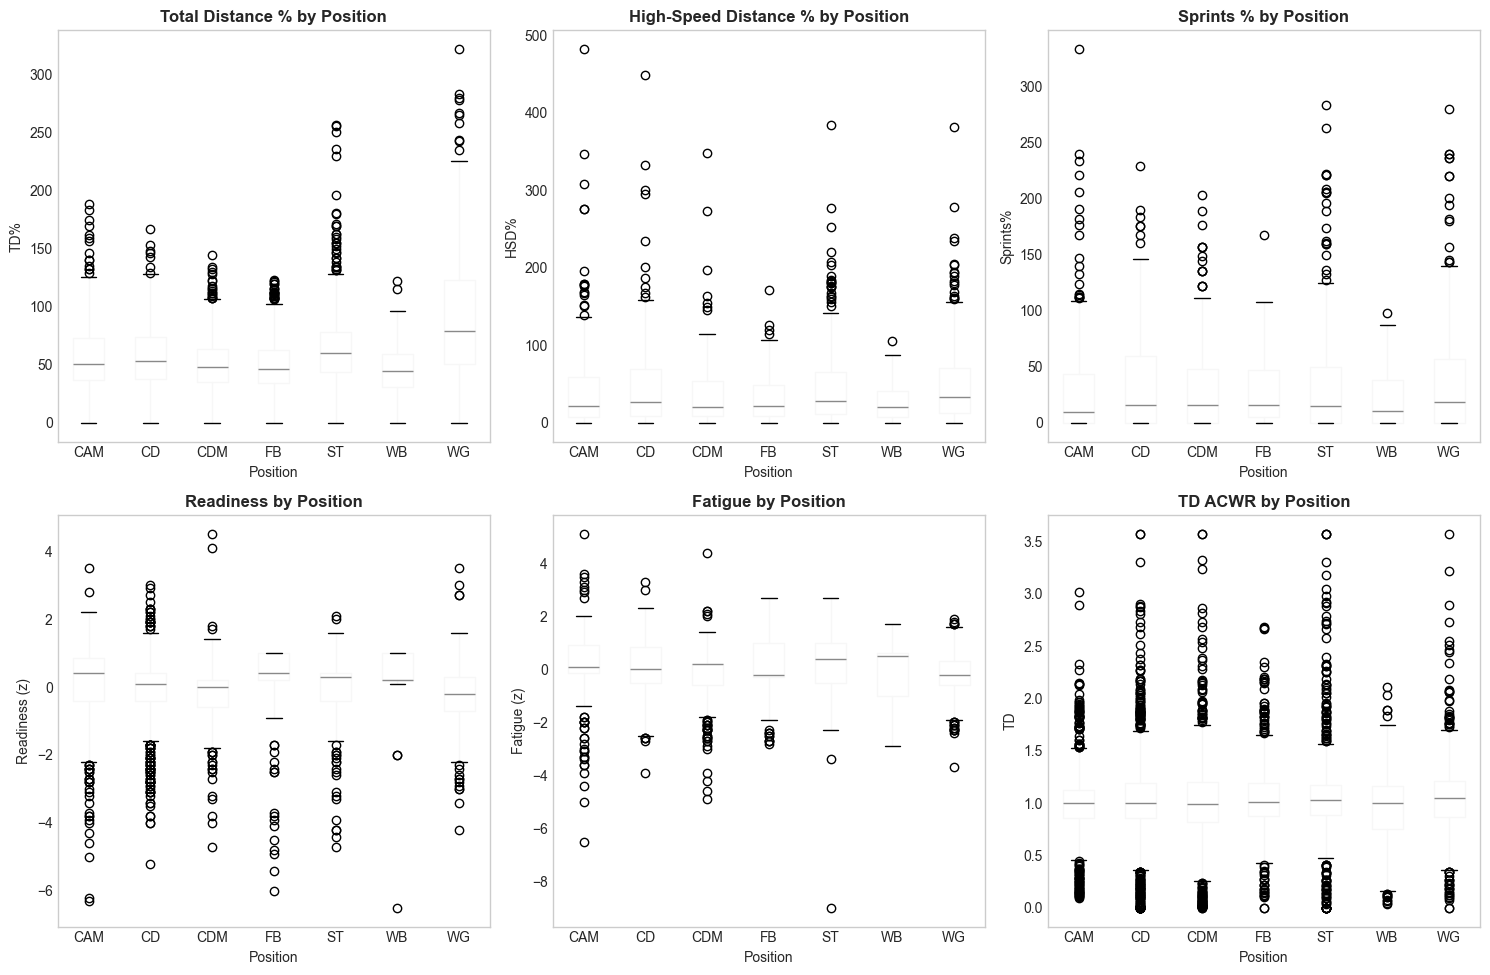

In [38]:
# Position comparison boxplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

metrics = ['TD%', 'HSD%', 'Sprints%', 'Readiness (z)', 'Fatigue (z)', 'TD']
titles = ['Total Distance %', 'High-Speed Distance %', 'Sprints %', 
          'Readiness', 'Fatigue', 'TD ACWR']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i]
    df.boxplot(column=metric, by='POS', ax=ax, grid=False)
    ax.set_xlabel('Position', fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.set_title(f'{title} by Position', fontsize=12, fontweight='bold')
    plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.show()

In [39]:
# Position physical profile radar
fig, axes = plt.subplots(2, 4, figsize=(16, 8), subplot_kw=dict(projection='polar'))
axes = axes.flatten()

radar_metrics = ['TD%', 'HSD%', 'Sprints%', 'Dec >3ms²%', 'Max, Velocity%']
positions = df['POS'].unique()

# Calculate position means
pos_means = df.groupby('POS')[radar_metrics].mean()

# Normalize for radar
pos_normalized = (pos_means - pos_means.min()) / (pos_means.max() - pos_means.min())

num_vars = len(radar_metrics)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

for i, pos in enumerate(positions):
    if i >= len(axes):
        break
    ax = axes[i]
    values = pos_normalized.loc[pos].tolist()
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=pos)
    ax.fill(angles, values, alpha=0.3)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(['TD', 'HSD', 'Spr', 'Dec', 'Vel'], fontsize=8)
    ax.set_title(pos, fontsize=12, fontweight='bold')

# Hide unused subplot
if len(positions) < len(axes):
    axes[-1].axis('off')

plt.suptitle('Physical Profile by Position (Normalized)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 11. Medical Status & Availability

In [40]:
# Status distribution over time
status_time = df.groupby(['Date', 'Status']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(14, 6))

status_colors = {
    'Available': COLORS['available'],
    'Attention': COLORS['attention'],
    'Injured': COLORS['injured'],
    'Sick': '#6B7280',
    'Absent': '#9CA3AF'
}

status_order = ['Available', 'Attention', 'Injured', 'Sick', 'Absent']
status_present = [s for s in status_order if s in status_time.columns]

ax.stackplot(status_time.index, 
             [status_time[s] for s in status_present],
             labels=status_present,
             colors=[status_colors[s] for s in status_present],
             alpha=0.8)

ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Number of Players', fontsize=11)
ax.set_title('Medical Status Distribution Over Time', fontsize=13, fontweight='bold')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [41]:
# Injury rate by position
injury_by_pos = df.groupby('POS').apply(
    lambda x: (x['Status'] == 'Injured').mean() * 100
).sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Injury rate by position
ax1 = axes[0]
ax1.bar(injury_by_pos.index, injury_by_pos.values, color=COLORS['injured'], edgecolor='white')
ax1.set_xlabel('Position', fontsize=11)
ax1.set_ylabel('Injury Rate %', fontsize=11)
ax1.set_title('Injury Rate by Position', fontsize=13, fontweight='bold')
ax1.axhline(y=injury_by_pos.mean(), color=COLORS['primary'], linestyle='--',
            label=f'Mean: {injury_by_pos.mean():.1f}%')
ax1.legend()

# Status by position stacked
ax2 = axes[1]
status_pos = df.groupby(['POS', 'Status']).size().unstack(fill_value=0)
status_pos_pct = status_pos.div(status_pos.sum(axis=1), axis=0) * 100

status_pos_pct[status_present].plot(kind='bar', stacked=True, ax=ax2,
                                     color=[status_colors[s] for s in status_present],
                                     edgecolor='white')
ax2.set_xlabel('Position', fontsize=11)
ax2.set_ylabel('Percentage', fontsize=11)
ax2.set_title('Status Distribution by Position', fontsize=13, fontweight='bold')
ax2.legend(title='Status', bbox_to_anchor=(1.02, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

C:\Users\U0152019\AppData\Local\Temp\ipykernel_28248\3679604144.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  injury_by_pos = df.groupby('POS').apply(


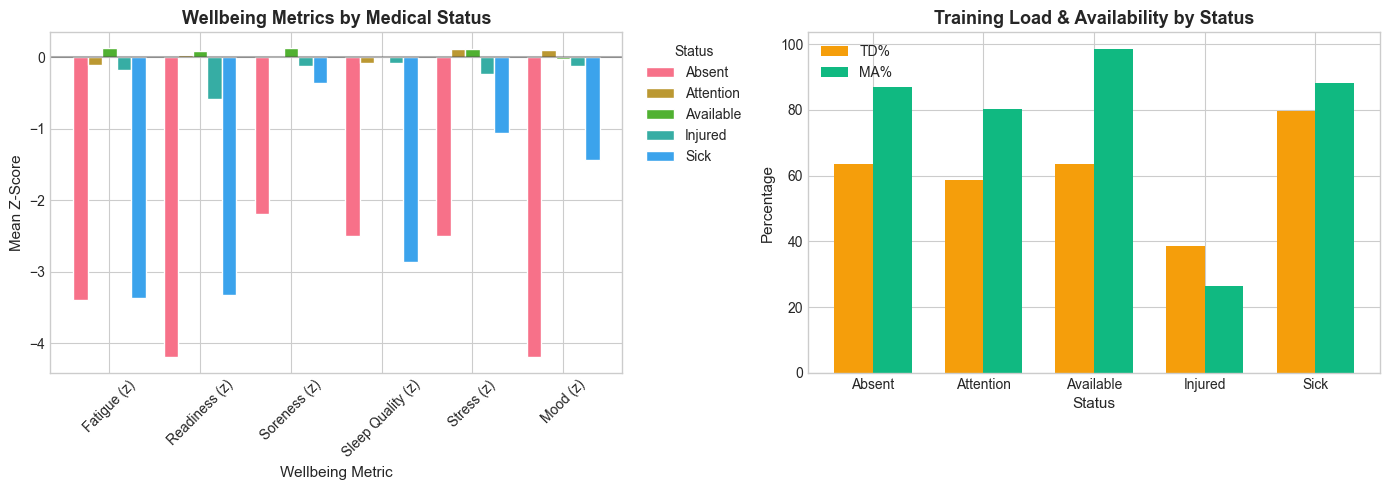

In [42]:
# Metrics comparison by status
status_metrics = df.groupby('Status')[WELLBEING_COLS + ['TD%', 'MA%']].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Wellbeing by status
ax1 = axes[0]
wellbeing_status = status_metrics[WELLBEING_COLS].T
wellbeing_status.plot(kind='bar', ax=ax1, width=0.8, edgecolor='white')
ax1.set_xlabel('Wellbeing Metric', fontsize=11)
ax1.set_ylabel('Mean Z-Score', fontsize=11)
ax1.set_title('Wellbeing Metrics by Medical Status', fontsize=13, fontweight='bold')
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title='Status', bbox_to_anchor=(1.02, 1), loc='upper left')

# TD% and MA% by status
ax2 = axes[1]
load_status = status_metrics[['TD%', 'MA%']]
x = np.arange(len(load_status))
width = 0.35
ax2.bar(x - width/2, load_status['TD%'], width, label='TD%', color=COLORS['previous'])
ax2.bar(x + width/2, load_status['MA%'], width, label='MA%', color=COLORS['current'])
ax2.set_xticks(x)
ax2.set_xticklabels(load_status.index)
ax2.set_xlabel('Status', fontsize=11)
ax2.set_ylabel('Percentage', fontsize=11)
ax2.set_title('Training Load & Availability by Status', fontsize=13, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

---
## 12. Key Insights & Summary

In [43]:
# Summary statistics
print("=" * 70)
print("KEY INSIGHTS SUMMARY")
print("=" * 70)

print("\n📊 DATASET OVERVIEW")
print(f"   • {df.shape[0]:,} observations across {df['Playerkey'].nunique()} players")
print(f"   • {df['Date'].nunique()} days of monitoring ({df['Date'].min().strftime('%b %d')} - {df['Date'].max().strftime('%b %d, %Y')})")
print(f"   • Average {df.shape[0] / df['Date'].nunique():.1f} player-observations per day")

print("\n⚠️ DATA QUALITY")
wellbeing_missing = df[WELLBEING_COLS].isna().mean().mean() * 100
print(f"   • Wellbeing data missing: {wellbeing_missing:.1f}%")
print(f"   • Comment field populated: {df['Comment'].notna().mean()*100:.1f}%")
print(f"   • RPE (z) missing: {df['rpe (z)'].isna().mean()*100:.1f}%")

print("\n🏃 WORKLOAD (ACWR)")
for col in ACWR_COLS:
    data = df[col].dropna()
    danger = (data > 1.5).mean() * 100
    print(f"   • {col}: Mean={data.mean():.2f}, >1.5 (danger): {danger:.1f}%")

print("\n💪 TRAINING LOAD (% of Benchmark)")
for col in BENCHMARK_COLS[:3]:
    data = df[col].dropna()
    above_match = (data > 100).mean() * 100
    print(f"   • {col}: Mean={data.mean():.1f}%, Above match level: {above_match:.1f}%")

print("\n😊 WELLBEING")
for col in ['Readiness (z)', 'Fatigue (z)', 'Soreness (z)']:
    data = df[col].dropna()
    print(f"   • {col.replace(' (z)', '')}: Mean={data.mean():.2f}, Std={data.std():.2f}")

print("\n🏥 AVAILABILITY")
available_pct = (df['Status'] == 'Available').mean() * 100
injured_pct = (df['Status'] == 'Injured').mean() * 100
print(f"   • Available: {available_pct:.1f}%")
print(f"   • Injured: {injured_pct:.1f}%")
print(f"   • Attention: {(df['Status'] == 'Attention').mean()*100:.1f}%")
print(f"   • Mean MA%: {df['MA%'].mean():.1f}%")

print("\n🔗 KEY CORRELATIONS WITH READINESS")
top_corrs = readiness_corr.head(3)
for var, corr in top_corrs.items():
    print(f"   • {var}: r = {corr:.3f}")

print("\n" + "=" * 70)

KEY INSIGHTS SUMMARY

📊 DATASET OVERVIEW
   • 4,239 observations across 27 players
   • 157 days of monitoring (jun 24 - nov 27, 2025)
   • Average 27.0 player-observations per day

⚠️ DATA QUALITY
   • Wellbeing data missing: 48.1%
   • Comment field populated: 8.3%
   • RPE (z) missing: 81.8%

🏃 WORKLOAD (ACWR)
   • TD: Mean=1.04, >1.5 (danger): 10.6%
   • HSD: Mean=1.02, >1.5 (danger): 12.4%
   • Dec >3ms²: Mean=1.03, >1.5 (danger): 11.9%
   • Sprints: Mean=1.00, >1.5 (danger): 14.0%

💪 TRAINING LOAD (% of Benchmark)
   • TD%: Mean=61.3%, Above match level: 13.3%
   • HSD%: Mean=41.1%, Above match level: 9.0%
   • Dec >3ms²%: Mean=52.9%, Above match level: 12.1%

😊 WELLBEING
   • Readiness: Mean=-0.03, Std=1.09
   • Fatigue: Mean=0.04, Std=1.05
   • Soreness: Mean=0.07, Std=1.00

🏥 AVAILABILITY
   • Available: 73.8%
   • Injured: 13.9%
   • Attention: 11.7%
   • Mean MA%: 86.4%

🔗 KEY CORRELATIONS WITH READINESS
   • Mood (z): r = 0.364
   • Sleep Quality (z): r = 0.329
   • Sorenes

In [44]:
# Final summary visualization
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)

# 1. Status pie
ax1 = fig.add_subplot(gs[0, 0])
status_counts = df['Status'].value_counts()
colors_pie = [status_colors.get(s, '#6B7280') for s in status_counts.index]
ax1.pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%',
        colors=colors_pie, explode=[0.02]*len(status_counts))
ax1.set_title('Medical Status Distribution', fontsize=12, fontweight='bold')

# 2. ACWR zones
ax2 = fig.add_subplot(gs[0, 1])
acwr_zones = {
    'Under (<0.8)': (df['TD'] < 0.8).mean() * 100,
    'Sweet (0.8-1.3)': ((df['TD'] >= 0.8) & (df['TD'] <= 1.3)).mean() * 100,
    'Caution (1.3-1.5)': ((df['TD'] > 1.3) & (df['TD'] <= 1.5)).mean() * 100,
    'Danger (>1.5)': (df['TD'] > 1.5).mean() * 100
}
zone_colors = ['#3B82F6', '#22C55E', '#F59E0B', '#EF4444']
ax2.bar(acwr_zones.keys(), acwr_zones.values(), color=zone_colors, edgecolor='white')
ax2.set_ylabel('Percentage %', fontsize=10)
ax2.set_title('TD ACWR Zone Distribution', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', rotation=30)

# 3. Position breakdown
ax3 = fig.add_subplot(gs[0, 2])
pos_counts = df['POS'].value_counts()
ax3.bar(pos_counts.index, pos_counts.values, color=sns.color_palette('husl', len(pos_counts)))
ax3.set_ylabel('Observations', fontsize=10)
ax3.set_title('Observations by Position', fontsize=12, fontweight='bold')

# 4. Wellbeing means
ax4 = fig.add_subplot(gs[1, 0])
wellbeing_means = df[WELLBEING_COLS].mean()
labels_short = ['Fatigue', 'Readiness', 'Soreness', 'Sleep', 'Stress', 'Mood']
colors_wb = ['#EF4444' if v < 0 else '#22C55E' for v in wellbeing_means]
ax4.barh(labels_short, wellbeing_means.values, color=colors_wb, edgecolor='white')
ax4.axvline(x=0, color='black', linestyle='-', alpha=0.3)
ax4.set_xlabel('Mean Z-Score', fontsize=10)
ax4.set_title('Average Wellbeing Profile', fontsize=12, fontweight='bold')

# 5. Load by day of week
ax5 = fig.add_subplot(gs[1, 1])
dow_load = df.groupby('DayName')['TD%'].mean().reindex(dow_order)
colors_dow = [COLORS['primary'] if d not in ['Saturday', 'Sunday'] else COLORS['accent'] 
              for d in dow_order]
ax5.bar(range(7), dow_load.values, color=colors_dow, edgecolor='white')
ax5.set_xticks(range(7))
ax5.set_xticklabels(['M', 'T', 'W', 'T', 'F', 'S', 'S'])
ax5.set_ylabel('Mean TD%', fontsize=10)
ax5.set_title('Training Load by Day of Week', fontsize=12, fontweight='bold')

# 6. Top correlations
ax6 = fig.add_subplot(gs[1, 2])
top_6_corr = readiness_corr.head(6)
colors_corr = ['#22C55E' if v > 0 else '#EF4444' for v in top_6_corr.values]
ax6.barh(range(len(top_6_corr)), top_6_corr.values, color=colors_corr, edgecolor='white')
ax6.set_yticks(range(len(top_6_corr)))
ax6.set_yticklabels(top_6_corr.index, fontsize=8)
ax6.set_xlabel('Correlation', fontsize=10)
ax6.set_title('Top Correlations with Readiness', fontsize=12, fontweight='bold')
ax6.invert_yaxis()

plt.suptitle('OHL Player Readiness Dataset - Executive Summary', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

C:\Users\U0152019\AppData\Local\Temp\ipykernel_28248\3599976135.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
